https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

In [4]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [5]:
# from torchvision import models
import torch
import torch
import torchvision #provides CV functionality and Datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
device = 'cuda'#changes CPU to run on GPU

hide_toggle()

TIME TO PRINT THE WEIGHTS OF A CNN IN IMAGE FORM

for p in resnet101.parameters():
    print(p)
    
for name, param in resnet101.state_dict().items():
    print(name)
    print(param)
    

for name, param in resnet101.state_dict().items():
    if 'conv' in name:
        print(name)
        

for name, layer in resnet101.state_dict().items():
    print(layer)

hide_toggle()

In [6]:
import torchvision.models as models
resnet101 = models.resnet101(pretrained=True)

from torchvision import transforms
transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
    mean=[0.485, 0.456, 0.406],                #[6]
    std=[0.229, 0.224, 0.225]                  #[7]
 )])


from PIL import Image
img = Image.open("dog.jpg")
img_t=transform(img)
batch_t=torch.unsqueeze(img_t,0)

hide_toggle()

In [15]:
resnet101


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

visulization using activation maximization
https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030 
visulizing using hooks
https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/

# First Try:-

Just managed to extract features from the end of each bottlneck layer in the resnet101

### Dog input

In [5]:
hide_toggle(for_next=True) #The hook for the resnet101 for the dog.jpg

In [6]:
#first the sequntial layer is printed in its entirety then the bottleneck layers inside that sequential layer are printed
#thus the entire resnet101 is printed twice

net = resnet101
visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o.clone().detach()

def get_all_layers(net):
    for name, layer in net._modules.items():
        print(layer)
        #If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            # it's a non sequential. Register a hook
            layer.register_forward_hook(hook_fn)


get_all_layers(net)

  
resnet101.eval()
out = resnet101(batch_t)
print(out.shape)

#printing the results of the input dog.jpg
'''with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
    
_, index = torch.max(out, 1)

percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

print(classes[index[0]],percentage[index[0]].item())'''


# Just to check whether we got all layers
#visualisation.keys()    #output includes sequential layers



Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

)
Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(

)
Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3

)
AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=2048, out_features=1000, bias=True)
torch.Size([1, 1000])


"with open('imagenet_classes.txt') as f:\n    classes = [line.strip() for line in f.readlines()]\n    \n_, index = torch.max(out, 1)\n\npercentage = torch.nn.functional.softmax(out, dim=1)[0] * 100\n\nprint(classes[index[0]],percentage[index[0]].item())"

In [7]:
#printing all the layer information
#U will notice i didn't access any of the convo layers inside the bottlenecks
num = 1
for layer in visualisation.keys():
    print(str(num)+" "+str(layer)+" ")
    num+=1

1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
2 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
3 ReLU(inplace=True) 
4 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 
5 Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


) 
19 Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
) 
20 Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False

) 
34 Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
) 
35 Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False

In [8]:
visualisation.values()

dict_values([tensor([[[[ 6.1331e-02, -1.6239e-01, -1.7198e-01,  ...,  1.8902e-01,
            1.3559e-01, -9.4176e-02],
          [-2.7069e-01,  1.5888e-01,  7.1724e-01,  ..., -1.7023e-01,
            9.0360e-02,  5.6708e-02],
          [ 2.5783e-01,  6.3776e-02, -1.1522e+00,  ...,  4.2647e-02,
           -4.9009e-02,  1.2186e-01],
          ...,
          [ 2.2649e+00,  2.7152e+00,  1.0704e+00,  ..., -1.0921e+00,
           -1.0122e+00, -4.5954e-01],
          [-1.2700e+00, -9.6585e-01,  1.5239e-01,  ...,  7.0934e-01,
            3.0337e-01,  1.6394e-01],
          [ 1.7473e-01,  1.3687e-01, -6.2768e-01,  ..., -3.9699e-01,
           -1.6869e-01, -2.0866e-01]],

         [[ 3.8156e-01,  5.1233e-02,  2.6119e-03,  ...,  2.1036e-02,
            3.7978e-01,  6.2984e-01],
          [ 2.9084e-02, -1.3515e-01, -1.6267e-02,  ..., -8.7734e-02,
           -5.5834e-02,  2.5961e-01],
          [-1.5975e-01, -3.7432e-02, -2.4292e-01,  ..., -1.0261e-02,
           -6.6678e-02, -1.6533e-01],
       

### Random Input

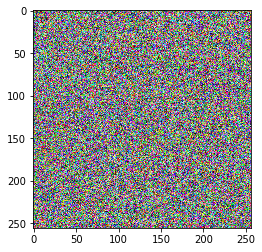

In [9]:
#Generating a random image(random numpy array 3 color channels)
'''sz = 256
img = np.uint8(np.random.uniform(150, 180, (256, 256, 3)))/25
'''

#creating a pytorch variable
#first transform the img into a tensor then define Variable
img_t = 150*torch.randn(1,3,256,256)    #tensor
img = np.uint8(img_t.reshape(256,256,3))
plt.imshow(img)
#print(img_t)
img_var = Variable(img_t, requires_grad=True)#wrap the tensor in pytorch variable

hide_toggle()

In [10]:
get_all_layers(net)
out = resnet101(img_var)
print(out.shape)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

)
Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(

)
Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3

)
AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=2048, out_features=1000, bias=True)
torch.Size([1, 1000])


In [11]:
visualisation.values()

dict_values([tensor([[[[-2.4272e+02, -6.1174e+02, -3.5767e+02,  ...,  1.3100e+02,
            4.7050e+02,  1.7998e+02],
          [ 1.3464e+02,  3.8515e+02,  4.3600e+02,  ...,  2.8035e+02,
            3.5808e+02,  2.0158e+02],
          [ 1.1086e+02,  1.6045e+02, -1.8913e+02,  ...,  2.8274e+02,
            2.7786e+02,  7.9672e+01],
          ...,
          [ 2.6646e+01,  1.2424e+02,  4.0991e+02,  ..., -3.5620e+00,
           -2.6958e+01, -3.4188e+01],
          [-1.6030e+02,  3.0386e+00,  2.3293e+02,  ..., -3.0864e+02,
           -2.9556e+02, -1.0546e+02],
          [-2.2279e+02, -1.2978e+02, -3.2865e+02,  ...,  2.0303e+02,
           -1.1800e+02, -1.2250e+02]],

         [[-8.9148e+01,  1.7089e+01, -6.3687e+02,  ..., -2.6034e+02,
           -3.7220e+02,  3.9256e+02],
          [ 2.4023e+00,  8.5856e+00,  7.4008e+02,  ..., -6.3934e+01,
            5.6397e+02, -5.5081e+02],
          [-1.7818e+02,  3.0937e+02, -4.2613e+02,  ...,  1.7641e+02,
           -2.2741e+02,  3.2519e+02],
       

# Second try:-


In [16]:
#there are a total of 104 convolutional layers in the resnet101 structure 4 of which are part of sequential layers inside 
#the bottleneck layers and are there for downsampleing the image. The following layers will be used for extracting features
num=1
for name, layer in net.named_modules():
    if 'conv' in name:
        print(str(num)+" "+str(name))
        print(layer)
        num+=1

1 conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2 layer1.0.conv1
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
3 layer1.0.conv2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
4 layer1.0.conv3
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
5 layer1.1.conv1
Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
6 layer1.1.conv2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
7 layer1.1.conv3
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
8 layer1.2.conv1
Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
9 layer1.2.conv2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
10 layer1.2.conv3
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
11 layer2.0.conv1
Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
12 layer2.0.conv2
Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2)

In [23]:
for name,layer in net.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [148]:
#this namelist will be used to name the images later on
n=0
namelist=[]
for name, layer in net.named_modules():
    if 'Bottleneck' not in str(layer):
        print(name)
        namelist.append(name)
        print(n)
        n+=1

conv1
0
bn1
1
relu
2
maxpool
3
layer1.0.conv1
4
layer1.0.bn1
5
layer1.0.conv2
6
layer1.0.bn2
7
layer1.0.conv3
8
layer1.0.bn3
9
layer1.0.relu
10
layer1.0.downsample
11
layer1.0.downsample.0
12
layer1.0.downsample.1
13
layer1.1.conv1
14
layer1.1.bn1
15
layer1.1.conv2
16
layer1.1.bn2
17
layer1.1.conv3
18
layer1.1.bn3
19
layer1.1.relu
20
layer1.2.conv1
21
layer1.2.bn1
22
layer1.2.conv2
23
layer1.2.bn2
24
layer1.2.conv3
25
layer1.2.bn3
26
layer1.2.relu
27
layer2.0.conv1
28
layer2.0.bn1
29
layer2.0.conv2
30
layer2.0.bn2
31
layer2.0.conv3
32
layer2.0.bn3
33
layer2.0.relu
34
layer2.0.downsample
35
layer2.0.downsample.0
36
layer2.0.downsample.1
37
layer2.1.conv1
38
layer2.1.bn1
39
layer2.1.conv2
40
layer2.1.bn2
41
layer2.1.conv3
42
layer2.1.bn3
43
layer2.1.relu
44
layer2.2.conv1
45
layer2.2.bn1
46
layer2.2.conv2
47
layer2.2.bn2
48
layer2.2.conv3
49
layer2.2.bn3
50
layer2.2.relu
51
layer2.3.conv1
52
layer2.3.bn1
53
layer2.3.conv2
54
layer2.3.bn2
55
layer2.3.conv3
56
layer2.3.bn3
57
layer2.3.relu

### RANDOM

In [1]:
#Registering hooks in each of the layers of the resnet
'''the way it registers is a bit weird 
First is hooks every individual layer inside a bottleneck then the bottleneck itself
after that it hooks the sequential layer as a whole after hooking all the bottleneck layers
finally the entire resnet is hooked'''

visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o.clone().detach()

def get_features(net):
    for name, layer in net.named_modules():
        layer.register_forward_hook(hook_fn)

        
get_features(resnet101)
out = resnet101(img_var)
print(out.shape)

NameError: name 'resnet101' is not defined

In [90]:
for i in visualisation.keys():
    if 'Bottleneck'not in str(i):
        print('_________________')
        print(i)

_________________
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
_________________
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
ReLU(inplace=True)
_________________
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
_________________
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
_________________
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
ReLU(inplace=True)
_________________
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
_________________
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
_________________
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
_______

_________________
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
_________________
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
ReLU(inplace=True)
_________________
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
_________________
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
_________________
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
_________________
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
_________________
ReLU(inplace=True)
_________________
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
_________________
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [110]:
for i in visualisation.values():
    print(i)

tensor([[[[ 255.2782, -113.7350,  140.3298,  ...,  628.9974,  968.4971,
            677.9778],
          [ 632.6422,  883.1533,  934.0016,  ...,  778.3527,  856.0797,
            699.5819],
          [ 608.8612,  658.4461,  308.8747,  ...,  780.7375,  775.8643,
            577.6717],
          ...,
          [ 524.6457,  622.2411,  907.9072,  ...,  494.4380,  471.0424,
            463.8118],
          [ 337.6993,  501.0386,  730.9288,  ...,  189.3592,  202.4417,
            392.5394],
          [ 275.2075,  368.2187,  169.3497,  ...,  701.0329,  380.0030,
            375.5034]],

         [[ 408.8521,  515.0894, -138.8724,  ...,  237.6584,  125.8015,
            890.5563],
          [ 500.4023,  506.5856, 1238.0786,  ...,  434.0660, 1061.9685,
            -52.8102],
          [ 319.8194,  807.3676,   71.8711,  ...,  674.4073,  270.5863,
            823.1868],
          ...,
          [ 396.8173,  498.7766,  151.8068,  ...,  440.5226,  583.7360,
            448.4897],
          [ 106.99

           4.6051e+00, 4.4577e+00]]]])
tensor([[[[101.8149, 146.4164, 146.4164,  ...,  73.7987,  74.1645, 124.3319],
          [101.8149, 115.2307,  58.3945,  ...,  73.7987,  74.7937,  94.6719],
          [  8.4003,  19.1355,  58.3945,  ..., 130.8730, 123.9149,  42.4864],
          ...,
          [ 53.0430, 121.4895, 199.8678,  ...,  86.4228,  91.8882,  52.6225],
          [ 82.4128, 113.6904, 113.6904,  ..., 100.2448, 102.3509,  25.3987],
          [ 32.9763, 149.0873, 175.3813,  ..., 100.2448, 102.3509,  53.7646]],

         [[  7.1362, 299.6267, 179.1505,  ..., 121.7353, 104.9629, 228.3801],
          [125.3795, 299.6267, 268.5291,  ..., 235.2906, 132.3145, 228.3801],
          [172.8972, 172.8972, 268.5291,  ..., 157.9379, 255.7803, 204.5672],
          ...,
          [190.7571, 130.0653, 285.1617,  ..., 253.8204, 253.8204, 109.1347],
          [ 46.0194, 143.1435, 357.5780,  ..., 253.8204, 253.8204, 161.6977],
          [172.7697, 134.6581, 164.3370,  ..., 238.5176, 217.2949, 129.

           -2.0471e-07, -2.0469e-07]]]])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2391e-03,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 1.9536e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.1635e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0441e-01,
           2.7077e-01, 1.9662e-01]],

         [[0.0000e+00, 1.6097e+01, 1.3857e+01,  ..., 0.0000e+00,
           0.0000e+00, 2.5968e+01],
          [0.0000e+00, 0.0000e+00, 6.9378e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.1356e+01],
          [0.0000e+00, 1.5067e+01, 1.8395e+01,  ..., 8.7822e+00,
           0.0000e+00, 3.2219e+00],
          ...,
          [0.0000e

            2.5241e+01,  1.2674e+01]]]])
tensor([[[[ 8.9101e-02,  1.0096e-01,  1.0361e-01,  ...,  2.4961e-01,
            1.4495e-01,  2.1619e-01],
          [ 9.3750e-02,  1.5203e-01,  1.8305e-01,  ...,  2.4599e-01,
            1.3857e-01,  1.6845e-01],
          [ 1.6394e-01,  2.1693e-01,  2.0643e-01,  ...,  4.4967e-01,
            4.1348e-01,  2.4282e-01],
          ...,
          [ 7.4495e-02,  3.1687e-01,  4.1953e-01,  ...,  2.3040e-01,
            1.6312e-01,  1.9902e-01],
          [ 1.3829e-01,  3.0350e-01,  3.1046e-01,  ...,  1.5533e-01,
            1.7167e-01,  2.2857e-01],
          [ 1.0249e-01,  2.1874e-01,  1.0781e-01,  ...,  4.1141e-01,
            4.1021e-01,  3.0683e-01]],

         [[ 1.2561e+00,  1.6912e+00,  2.8686e+00,  ...,  1.9854e+00,
           -1.8860e+00,  3.0403e-01],
          [ 1.6599e+00, -1.3998e+00,  4.2024e+00,  ...,  3.4870e+00,
           -1.1937e+00, -7.9765e-01],
          [-1.4721e+00,  7.9098e-04,  3.3462e+00,  ...,  1.1089e+00,
           -4.480

           -1.2330e+01, -5.1513e+00]]]])
tensor([[[[-4.9978e-01, -7.5889e-01, -7.1029e-01,  ..., -7.0199e-01,
           -6.8784e-01, -6.1408e-01],
          [-6.8466e-01, -6.9488e-01, -8.1002e-01,  ..., -9.3148e-01,
           -9.1501e-01, -6.8110e-01],
          [-7.0608e-01, -6.6687e-01, -8.3945e-01,  ..., -1.1515e+00,
           -1.1879e+00, -9.9680e-01],
          ...,
          [-7.0187e-01, -9.2147e-01, -8.7882e-01,  ..., -7.5218e-01,
           -8.6611e-01, -7.7640e-01],
          [-4.7460e-01, -6.5559e-01, -8.9285e-01,  ..., -7.1810e-01,
           -7.5844e-01, -6.0822e-01],
          [-4.9576e-01, -7.8818e-01, -1.1932e+00,  ..., -7.4863e-01,
           -7.7916e-01, -5.8398e-01]],

         [[-2.0300e+01,  1.2761e+01,  8.1172e+00,  ..., -5.8063e+00,
           -1.1686e+01,  2.5463e+01],
          [-6.5573e+00, -2.1213e+00, -1.5252e+00,  ..., -1.1919e+01,
           -2.1300e+01,  2.3100e+01],
          [ 2.1498e+00,  1.5182e+01,  1.1680e+01,  ...,  6.6345e+00,
           -2.197

           0.0000e+00, 0.0000e+00]]]])
tensor([[[[-1.0433e-05, -1.1529e-05, -1.0172e-05,  ..., -1.2966e-05,
           -1.1220e-05, -6.6496e-06],
          [-2.0082e-05, -1.1501e-05, -1.1210e-05,  ..., -1.0188e-05,
           -1.0581e-05, -8.4104e-06],
          [-1.9847e-05, -1.0217e-05, -1.4662e-05,  ..., -1.9405e-05,
           -1.6433e-05, -1.6777e-05],
          ...,
          [-1.2317e-05, -1.5194e-05, -1.4837e-05,  ..., -1.1809e-05,
           -6.8858e-06, -7.5780e-06],
          [-8.4453e-06, -1.1012e-05, -7.1191e-06,  ..., -1.2151e-05,
           -9.1273e-06, -1.0755e-05],
          [-6.9413e-06, -6.6201e-06, -1.1885e-05,  ..., -9.7209e-06,
           -6.4856e-06, -7.8806e-06]],

         [[ 1.0518e+00, -2.8809e+00, -7.1517e+00,  ..., -2.2210e+00,
           -8.0824e+00, -5.8634e+00],
          [ 3.4587e+00, -7.5148e-01, -3.0909e+00,  ...,  2.4818e+00,
            2.8940e+00, -7.2476e+00],
          [ 5.2325e+00,  2.3360e+00, -6.7857e-01,  ..., -8.8212e-01,
            1.2161e

           0.0000e+00, 0.0000e+00]]]])
tensor([[[[ 5.4436e-04,  8.9976e-04,  1.0313e-03,  ...,  1.0320e-03,
            9.9140e-04,  6.5811e-04],
          [ 8.6041e-04,  1.3690e-03,  1.4698e-03,  ...,  1.6759e-03,
            1.6511e-03,  1.0730e-03],
          [ 1.0476e-03,  1.4994e-03,  1.5188e-03,  ...,  2.0508e-03,
            1.9498e-03,  1.3055e-03],
          ...,
          [ 9.6308e-04,  1.4207e-03,  1.5252e-03,  ...,  1.4571e-03,
            1.4661e-03,  9.9469e-04],
          [ 8.2525e-04,  1.2796e-03,  1.4875e-03,  ...,  1.4154e-03,
            1.4321e-03,  9.2125e-04],
          [ 5.4354e-04,  8.5659e-04,  1.0340e-03,  ...,  9.7557e-04,
            9.8564e-04,  6.3313e-04]],

         [[-2.6647e+01, -4.0078e+01, -4.2656e+01,  ..., -4.5478e+01,
           -4.2273e+01, -2.8400e+01],
          [ 9.3075e-01,  3.0993e+00,  5.8882e+00,  ..., -1.6212e+00,
           -5.8574e+00, -5.7454e+00],
          [ 1.4049e+01,  8.1851e+00,  7.0377e+00,  ..., -5.9137e-01,
           -7.2066e

           -4.5048e+00, -7.4698e+00]]]])
tensor([[[[-3.7277e-03, -3.8556e-03, -3.9492e-03,  ..., -3.8792e-03,
           -3.8346e-03, -3.7655e-03],
          [-3.9528e-03, -4.1902e-03, -4.3385e-03,  ..., -4.2538e-03,
           -4.2176e-03, -3.9914e-03],
          [-4.0553e-03, -4.3102e-03, -4.3631e-03,  ..., -4.3375e-03,
           -4.3132e-03, -4.0455e-03],
          ...,
          [-3.8342e-03, -4.2766e-03, -4.3169e-03,  ..., -4.2893e-03,
           -4.2356e-03, -4.0719e-03],
          [-3.8634e-03, -4.2711e-03, -4.3293e-03,  ..., -4.2690e-03,
           -4.2027e-03, -3.9961e-03],
          [-3.7390e-03, -4.0335e-03, -4.1043e-03,  ..., -4.0413e-03,
           -4.0115e-03, -3.8927e-03]],

         [[-1.3372e-02,  2.5333e-02, -2.6603e-01,  ..., -4.1803e-01,
           -3.1645e-01, -1.3951e+00],
          [-6.8357e-01, -1.9727e-02, -7.5521e-01,  ..., -8.5967e-01,
           -9.0551e-01, -2.0262e+00],
          [-1.4744e+00, -4.6322e-01, -6.0268e-01,  ..., -1.3698e+00,
           -1.519

          [ -0.7550, -12.2983, -12.4575,  ...,   9.9518,   6.3490,  -3.3400]]]])
tensor([[[[-46.5125, -18.0187, -36.4503,  ..., -36.5007, -32.0619,  -6.3467],
          [-64.1016, -24.9033, -29.6045,  ..., -46.8194, -26.6780, -21.0432],
          [-71.5233, -61.4800, -66.5706,  ..., -66.3334, -43.1433, -35.5891],
          ...,
          [ -9.6541, -49.9942, -41.3693,  ..., -26.0916, -72.9097, -34.2051],
          [-32.6119, -51.3506, -76.5449,  ..., -39.4485, -35.1924, -21.6514],
          [-19.6132, -30.3606, -41.3981,  ..., -18.7441,  15.1710, -13.1740]],

         [[ 27.9521,  13.3210,  20.0406,  ...,  16.9907,  23.0219,  41.2736],
          [ 41.9846,  12.9458,  22.6314,  ...,  29.8061,  15.2262,  46.7657],
          [ 59.5572,  24.4761,  28.9513,  ...,  50.9916,  38.6613,  46.2486],
          ...,
          [ 31.7752,  43.7337,   8.2255,  ...,  24.1938,  10.1989,  36.4804],
          [ 29.0112,  32.1621,  17.7094,  ...,  18.8870,   9.5005,  26.1079],
          [ 19.6955,  37.6698

          [-17.1465, -20.5933, -14.2745,  ..., -12.1358, -12.0902,  -6.5546]]]])
tensor([[[[ -7.4259, -10.9234, -15.2869,  ..., -20.6063, -23.4501,  -4.4794],
          [-16.6981, -28.2795,  -8.6833,  ..., -25.3918, -22.3985,  -5.7177],
          [-22.0737, -27.3787,  -2.1069,  ..., -39.8775, -14.6244,  -0.8099],
          ...,
          [-22.0236, -21.4726,  -8.9659,  ..., -12.4490, -13.6214,   3.2501],
          [-13.0716, -34.6271,  -7.5611,  ...,  -5.3327,  -9.1036,   0.9780],
          [-14.9745, -25.1379,  -4.8021,  ...,  -4.9198,  -2.6650,  -8.8715]],

         [[ 30.8988,  41.3259,  36.6095,  ...,  42.0150,  40.3213,  22.7909],
          [ 33.3217,  54.3877,  46.7737,  ...,  57.7108,  65.5227,  45.7115],
          [ 30.6465,  53.5104,  44.2475,  ...,  61.4687,  63.6585,  42.3628],
          ...,
          [ 31.8643,  55.6914,  49.9950,  ...,  37.4885,  51.1582,  33.5339],
          [ 41.5443,  66.9569,  66.0664,  ...,  52.8984,  54.5230,  33.0731],
          [ 12.6893,  31.6332

           -8.3075e+00, -6.8663e+00]]]])
tensor([[[[1.4077e-04, 1.3746e-04, 1.4744e-04,  ..., 1.5688e-04,
           1.4668e-04, 1.6876e-04],
          [1.6619e-04, 1.4532e-04, 1.5897e-04,  ..., 1.7107e-04,
           1.5654e-04, 1.8594e-04],
          [1.9317e-04, 1.6893e-04, 1.6917e-04,  ..., 1.9131e-04,
           1.8174e-04, 2.0199e-04],
          ...,
          [1.5468e-04, 1.8756e-04, 1.9121e-01,  ..., 1.7102e-04,
           1.5666e-04, 1.8713e-04],
          [1.5512e-04, 1.1226e-01, 1.5651e-04,  ..., 1.6912e-04,
           1.5484e-04, 1.7403e-04],
          [1.5105e-04, 1.6834e-04, 1.6069e-04,  ..., 3.0053e-01,
           2.6691e-01, 1.9288e-01]],

         [[0.0000e+00, 1.6267e+01, 1.1581e+01,  ..., 0.0000e+00,
           0.0000e+00, 1.7108e+01],
          [0.0000e+00, 0.0000e+00, 2.9758e+00,  ..., 0.0000e+00,
           0.0000e+00, 7.6122e+00],
          [0.0000e+00, 8.4181e+00, 1.2581e+01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e

          [-21.7846, -30.0265, -43.8405,  ..., -23.2193, -16.9080, -19.5270]]]])
tensor([[[[ -12.7627,   -0.6387,    7.6296,  ...,   18.7922,   11.4348,
              5.7135],
          [   5.4178,   20.8530,   18.6452,  ...,   26.1513,   31.8268,
              8.3749],
          [  19.7967,   39.2563,   13.3768,  ...,   25.3467,   40.7368,
             17.5150],
          ...,
          [  15.3000,   32.0537,   26.8048,  ...,   25.7234,   49.0842,
             14.2056],
          [  19.3607,   35.3898,   37.7370,  ...,   31.9505,   36.4746,
              7.2673],
          [  14.7899,   32.0568,   26.3869,  ...,   16.0600,   23.2309,
              7.7326]],

         [[  -5.4119,   -0.5749,   -6.5238,  ...,  -12.0909,  -18.5175,
            -17.5982],
          [ -11.3402,   -3.7814,   -6.7674,  ...,  -16.0642,   -1.6395,
            -13.6720],
          [ -22.7702,   -6.8314,  -18.2932,  ...,  -42.5845,  -17.7896,
            -16.2118],
          ...,
          [ -12.0855,  -11.4196,

          [-20.7361,  11.0493, -14.9834,  ...,  -9.0743, -11.0146,  -3.8188]]]])
tensor([[[[-2.3186e+01, -1.1573e+01, -2.4104e-01,  ..., -4.0726e+00,
           -6.1192e+00, -9.5057e+00],
          [ 5.6560e+00, -9.2605e+00,  7.9206e+00,  ...,  7.5903e+00,
           -8.9501e+00, -1.3353e+01],
          [ 8.8875e-01, -1.0127e+01,  1.6675e+00,  ...,  1.5559e+01,
           -4.9879e+00, -1.3077e+01],
          ...,
          [-1.0606e+01, -5.0273e+00, -2.9261e+00,  ..., -1.1048e+01,
           -1.0159e+00, -7.3025e+00],
          [-1.9787e+01, -2.6208e+00,  1.0942e+01,  ..., -7.7876e+00,
           -1.2270e+00,  1.5127e+00],
          [-1.2783e+01, -2.9167e+01,  1.5640e+01,  ..., -1.0847e+01,
           -4.8239e+00,  9.8698e+00]],

         [[ 1.9452e+01,  1.0958e+01,  4.8592e+00,  ...,  1.8943e+01,
            1.6106e+01,  1.7135e+01],
          [ 5.6102e+00,  2.9646e+01,  1.4822e+01,  ...,  2.7466e+01,
            1.1015e-02,  1.8530e+01],
          [ 8.3752e+00,  1.3914e+01,  1.8608e+

          [ -4.7223,  12.6409,  -5.8731,  ...,   3.2254,   3.0052,   6.3009]]]])
tensor([[[[ 2.0923e+01,  2.0073e+01,  2.9456e+01,  ...,  1.3494e+01,
            2.3663e+01,  1.0721e+01],
          [ 2.7828e+01,  2.2132e+01,  2.5673e+01,  ...,  2.6770e+01,
            2.1124e+01,  2.2065e+01],
          [ 9.8243e+00,  1.8518e+01,  1.4625e+01,  ...,  1.4996e+01,
            2.1843e+01,  2.5545e+01],
          ...,
          [ 1.5613e+01,  1.5639e+01,  2.7539e+01,  ...,  2.0500e+01,
            2.7547e+01,  3.0438e+01],
          [ 1.7506e+01,  3.0853e+01,  2.8871e+01,  ...,  2.2858e+01,
            1.8983e+01,  1.8579e+01],
          [ 3.1128e+01,  3.0341e+01,  2.1276e+01,  ...,  3.1585e+01,
            2.7118e+01,  1.3050e+01]],

         [[-3.8382e+00, -4.6494e+00, -2.6705e+00,  ..., -2.7320e+00,
           -6.8815e+00, -3.8151e+00],
          [-3.2024e+00, -2.9678e+00, -2.0360e+00,  ..., -1.1678e+01,
            3.3457e+00, -8.0215e+00],
          [ 1.4100e+00,  7.1157e-02, -1.1818e-

           -7.2091e-01, -6.0173e+00]]]])
tensor([[[[1.6595e+01, 1.6214e+01, 2.3552e+01,  ..., 1.0148e+01,
           1.8612e+01, 8.1168e+00],
          [2.0409e+01, 1.7759e+01, 1.9574e+01,  ..., 1.9699e+01,
           1.5041e+01, 1.6629e+01],
          [4.2958e+00, 1.3432e+01, 1.0515e+01,  ..., 9.2520e+00,
           1.5129e+01, 1.9039e+01],
          ...,
          [9.5508e+00, 1.1087e+01, 2.1545e+01,  ..., 1.5231e+01,
           2.1342e+01, 2.3296e+01],
          [1.1577e+01, 2.4128e+01, 2.2119e+01,  ..., 1.7733e+01,
           1.4620e+01, 1.3875e+01],
          [2.3444e+01, 2.4189e+01, 1.5867e+01,  ..., 2.5012e+01,
           2.1185e+01, 9.6077e+00]],

         [[0.0000e+00, 0.0000e+00, 1.0516e+01,  ..., 2.3398e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           4.1390e+00, 0.0000e+00],
          [0.0000e+00, 2.2471e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e

          [ 19.6863,  42.4276,  30.9022,  ...,  31.3234,  27.3274,  27.4036]]]])
tensor([[[[ 0.0000, 15.9019, 26.5609,  ..., 10.0103,  0.0000,  0.0000],
          [ 0.0000, 24.2532, 20.0036,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, 17.9270,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  9.6284,  9.3251,  ...,  0.0000,  8.9847,  0.0000],
          [ 0.0000, 21.3519,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 9.7252,  7.5280,  0.0000,  ..., 21.3879,  1.2640,  0.0000]],

         [[ 0.0000,  0.0000,  9.8791,  ...,  1.3998,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  2.3052,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 4.3466,  

            4.0548e+01,  8.2126e+00]]]])
tensor([[[[-5.3865e+00, -1.0652e-01,  9.4938e-01,  ..., -5.0976e-02,
           -6.5251e+00, -3.2799e+00],
          [-1.1477e+01,  2.0574e+00,  1.2937e-01,  ..., -8.1792e+00,
           -1.1182e+01, -5.3063e+00],
          [-9.9720e+00,  1.4219e+00, -4.5835e+00,  ..., -1.4308e+01,
           -6.5505e+00, -6.9858e+00],
          ...,
          [-1.0277e+01, -4.7095e-01, -3.8923e+00,  ..., -9.9292e+00,
           -3.9361e+00, -7.8283e+00],
          [-8.4722e+00, -8.8976e-01, -8.3735e+00,  ..., -7.1779e+00,
           -9.0187e+00, -5.6354e+00],
          [-4.3687e+00, -5.3043e+00, -9.2082e+00,  ..., -1.1596e+00,
           -6.3408e+00, -8.3872e+00]],

         [[-1.0980e+01, -8.7039e-01, -6.4364e+00,  ..., -9.4731e+00,
           -9.4037e+00, -8.0759e+00],
          [-2.7269e+01, -2.1359e+00, -1.0243e+01,  ..., -1.9972e+01,
           -1.8431e+01, -1.4525e+01],
          [-3.9993e+01, -8.9289e+00, -1.3152e+01,  ..., -2.7008e+01,
           -1.862

          [ 0.0000,  6.6017,  0.0000,  ...,  7.5525, 15.1242,  0.6416]]]])
tensor([[[[-2.0141e+01, -2.2090e+01, -2.2548e+01,  ..., -1.7385e+01,
           -3.0162e+01, -3.0867e+01],
          [-2.5351e+01, -2.0602e+01, -2.9091e+01,  ..., -3.2684e+01,
           -2.5623e+01, -2.5863e+01],
          [-2.5000e+01, -2.7270e+01, -2.5417e+01,  ..., -2.9986e+01,
           -2.8276e+01, -2.7825e+01],
          ...,
          [-2.1656e+01, -2.3273e+01, -2.8930e+01,  ..., -3.0540e+01,
           -2.8859e+01, -2.7046e+01],
          [-1.8306e+01, -2.6867e+01, -2.7760e+01,  ..., -2.7778e+01,
           -2.6102e+01, -2.8395e+01],
          [-2.7653e+01, -3.7576e+01, -2.4814e+01,  ..., -2.5361e+01,
           -2.5139e+01, -1.5291e+01]],

         [[ 9.9008e+00,  6.6987e-01,  6.9678e+00,  ..., -9.0428e+00,
           -1.2971e+00,  3.0354e+00],
          [-1.5088e+00,  7.8133e+00, -3.0858e+00,  ..., -6.7135e+00,
           -8.3451e+00, -7.3082e+00],
          [-2.4891e+01, -2.3976e+00,  6.9548e-01,  .

          [12.9114, 21.2025, 13.7830,  ..., 21.2386, 28.4944, 10.3688]]]])
tensor([[[[  1.6352,  -2.1089,  -5.5570,  ...,   2.5500,   2.8748,  -0.5492],
          [ -2.4971,  -6.2879, -14.3738,  ...,  -9.0859,  -3.4655,  -3.5683],
          [ -0.4615,  -0.8070,  -7.0909,  ..., -11.3362,  -5.5061,  -6.1519],
          ...,
          [ -4.1450,  -3.4304,  -5.1637,  ...,  -6.8508, -11.5617, -10.9302],
          [ -3.0805,  -7.3271, -13.1006,  ...,  -9.6242, -11.6007,  -7.2850],
          [ -0.4999,  -5.6113,  -8.3298,  ...,  -5.1701,  -8.1984,  -7.1713]],

         [[ 15.9939,  16.5990,  22.1890,  ...,  22.7789,  20.4912,  11.7442],
          [ 25.9743,  24.0120,  30.7590,  ...,  31.7651,  25.8846,  12.7090],
          [ 27.8178,  22.4924,  23.6529,  ...,  25.6234,  22.6391,  11.2891],
          ...,
          [ 24.2863,  19.6543,  19.4112,  ...,  24.1392,  22.5027,   8.9518],
          [ 19.5862,  12.1975,  18.4553,  ...,  25.2044,  20.8927,  10.2575],
          [ 11.6932,   5.7853,   4.

          [  5.6368,   6.3727,   6.0165,  ...,   5.9743,   5.8367,   4.2498]]]])
tensor([[[[  2.1244,   0.2003,   1.3819,  ...,   1.8532,   2.0597,   2.0957],
          [  5.4317,   0.6607,   2.5332,  ...,   4.0136,   3.8948,   3.9088],
          [  8.0257,   1.9612,   3.3488,  ...,   5.7087,   4.0110,   5.3590],
          ...,
          [  7.3248,   2.6947,   1.6040,  ...,   2.7947,   1.9895,   5.5405],
          [  6.5995,   1.8678,   2.4291,  ...,   2.1906,   1.6802,   3.7917],
          [  4.0204,   1.1092,   2.0560,  ...,   1.2279,   1.2651,   2.2484]],

         [[  6.4568,   0.1338,   3.9921,  ...,   5.5428,   6.3338,   6.9322],
          [ 17.8470,   2.2398,   8.6060,  ...,  13.1720,  12.8854,  13.3089],
          [ 26.4329,   6.5329,  11.5396,  ...,  19.2780,  13.4877,  18.1511],
          ...,
          [ 24.0871,   9.0302,   5.5232,  ...,   9.5520,   6.8957,  18.8613],
          [ 21.6929,   6.2429,   8.2126,  ...,   7.4674,   5.7985,  12.9108],
          [ 13.4453,   4.1391

          [-10.3423, -16.7423,  -9.8027,  ..., -12.6732, -14.5177, -10.3757]]]])
tensor([[[[-1.0779e+01, -2.3656e+01, -1.1059e+01,  ..., -1.1366e+01,
           -9.1353e+00, -1.8994e+01],
          [-1.2715e+01, -1.4029e+01, -1.7766e+01,  ..., -9.4978e+00,
           -1.2116e+01, -2.1113e+01],
          [-2.3349e+01, -7.6930e+00, -1.2295e+01,  ..., -1.4644e+01,
           -1.8596e+01, -2.8618e+01],
          ...,
          [-2.2081e+01, -1.1967e+01, -9.7608e+00,  ..., -2.1500e+01,
           -1.3950e+01, -2.4339e+01],
          [-1.8628e+01, -1.1611e+01, -6.0431e+00,  ..., -1.3141e+01,
           -1.4184e+01, -1.5742e+01],
          [-1.3635e+01, -1.6070e+01, -1.4217e+01,  ..., -1.4638e+01,
           -1.7152e+01, -1.3235e+01]],

         [[-2.2663e+01, -1.1146e+01, -1.4433e+01,  ..., -8.9741e+00,
           -8.9280e+00, -1.2714e+01],
          [-1.3034e+01, -5.0619e+00, -2.1892e+00,  ..., -2.5620e+00,
           -8.1232e+00, -1.2942e+01],
          [-3.0255e+01, -5.1148e+00,  4.3596e-

           -5.6240e+00, -5.8909e+00]]]])
tensor([[[[ 6.6604e+00, -7.2396e+00,  1.5117e+01,  ...,  6.0443e+00,
            2.1525e+00, -2.8095e+00],
          [ 1.2393e+01, -1.8067e+01,  3.7642e-02,  ...,  6.8388e+00,
           -7.9025e+00, -3.8409e+00],
          [ 4.0729e+00, -1.0297e+01, -4.2006e+00,  ...,  1.4526e+01,
           -6.7069e+00, -1.0267e+00],
          ...,
          [ 5.9512e+00, -1.4551e+01,  1.6646e+00,  ...,  6.9493e-01,
           -1.1196e+01,  8.7901e+00],
          [ 7.3618e-01, -1.4527e+01,  3.0953e+00,  ..., -4.6983e+00,
           -5.5039e+00,  8.9154e-03],
          [-2.2686e-01, -1.5841e+01, -1.2210e+00,  ..., -1.1025e+01,
           -1.2272e+01, -2.3271e+00]],

         [[-5.3654e-01, -5.3537e+00, -8.5341e+00,  ..., -1.6273e+01,
           -9.0973e+00, -1.1957e+00],
          [ 6.7922e-01, -7.5324e+00, -8.8255e+00,  ..., -1.0096e+01,
           -1.2541e+01, -1.0135e+01],
          [ 2.8852e+00, -7.7262e+00, -8.5311e+00,  ..., -6.2106e+00,
           -1.572

          [-35.8134, -10.3117, -17.3625,  ..., -10.6808, -10.0351, -18.7680]]]])
tensor([[[[ 0.0000, 15.0541, 25.0436,  ...,  7.0211,  0.0000,  0.0000],
          [ 0.0000, 22.3808, 16.9157,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, 14.3784,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  5.9885,  6.6772,  ...,  0.0000,  5.7181,  0.0000],
          [ 0.0000, 18.3353,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 4.0689,  6.1219,  0.0000,  ..., 20.0799,  0.3506,  0.0000]],

         [[ 0.0000,  2.7376, 14.7329,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.7207,  0.0000,  ...,  0.0000,  0.3342,  0.0000],
          ...,
          [ 0.0000,  4.4954,  1.9814,  ...,  4.0708,  1.5980,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  

           -3.1958e+01, -4.0166e+01]]]])
tensor([[[[-8.7884e+00, -7.5153e+00, -1.2260e+01,  ..., -2.0003e+01,
           -4.5624e+00, -7.3811e+00],
          [-3.5301e+01, -7.5171e+00, -1.2852e+01,  ..., -3.6801e+01,
           -4.0647e+01, -4.5070e+01],
          [-4.3028e+01, -3.5812e+01, -2.3879e+01,  ..., -4.8519e+01,
           -4.7046e+01, -4.4785e+01],
          ...,
          [-4.1106e+01, -2.7152e+01, -1.9412e+01,  ..., -1.9172e+01,
           -2.4298e+01, -3.6898e+01],
          [-3.4566e+01, -1.0362e+01, -3.1154e+01,  ..., -1.5820e+01,
           -1.6417e+01, -2.9214e+01],
          [-2.4521e+01, -2.1944e+01, -1.4661e+01,  ..., -9.2689e-01,
            6.0936e+00, -2.7384e+01]],

         [[-3.9608e+01, -4.3379e+01, -5.1425e+01,  ..., -4.7136e+01,
           -4.6816e+01, -2.6642e+01],
          [-4.7698e+01, -4.5857e+01, -4.7429e+01,  ..., -5.9930e+01,
           -5.7319e+01, -4.1394e+01],
          [-6.8598e+01, -5.1324e+01, -4.8052e+01,  ..., -5.2254e+01,
           -4.026

          [  1.2812,   5.5336,   8.1138,  ...,   8.9413,   3.5181,   9.7219]]]])
tensor([[[[ -2.9746,   0.6299,   8.1111,  ...,  10.7618,   6.2946,   4.4329],
          [  0.6432,  10.0814,   3.0144,  ...,   1.3583,   6.7104,  13.1725],
          [ -1.7465,   3.7677,   0.8406,  ...,   4.9241,   2.7328,   7.1033],
          ...,
          [ -1.3503,  -1.8602,   5.1010,  ...,   8.0619,   0.2221,   6.5760],
          [  2.3409,  11.2608,   6.3267,  ...,   9.6290,   3.6160,   4.5190],
          [ -4.4051,  -2.5115,   1.9158,  ...,   0.0644,  -2.0177,  -4.0967]],

         [[ 17.3110,  17.4581,  12.7460,  ...,  10.2569,   8.8655,  11.7800],
          [ 12.6798,  15.2683,  20.2901,  ...,  22.4153,  16.5743,   9.7006],
          [ 12.4008,  15.2925,  25.8085,  ...,  32.9004,  19.9498,  14.9501],
          ...,
          [ 10.9926,  24.5998,  27.0205,  ...,  12.0730,  27.8012,  12.5453],
          [  8.3875,  20.4898,  24.6068,  ...,  13.1424,  19.6770,  12.6256],
          [ 18.0831,  19.7344

            3.1711e-01,  5.2961e-01]]]])
tensor([[[[-3.4280e-05, -2.0656e-05, -1.9859e-05,  ..., -3.0571e-05,
           -1.8950e-05, -3.7250e-05],
          [-5.6146e-06, -4.8085e-06, -1.0486e-05,  ...,  4.3096e-06,
           -2.2501e-06,  1.2034e-05],
          [-2.9989e-05, -9.9079e-06, -1.7131e-05,  ..., -1.1037e-05,
           -9.6819e-06,  3.3178e-06],
          ...,
          [ 3.4445e-06, -1.3711e-05,  4.8378e-06,  ..., -9.4151e-06,
           -1.6593e-05,  6.0067e-08],
          [-2.8333e-05, -2.5812e-05, -1.5829e-05,  ..., -1.6576e-05,
           -2.7462e-05, -1.6423e-05],
          [-1.5731e-05, -1.9488e-05, -5.1035e-06,  ..., -2.0429e-05,
           -1.8785e-05, -5.0560e-06]],

         [[ 4.4383e+00,  8.1816e+00,  1.0156e+01,  ...,  1.0881e+01,
            9.3104e+00,  1.1582e+01],
          [ 9.5935e+00,  9.2471e+00,  9.0774e+00,  ...,  9.0202e+00,
            7.6801e+00,  9.7514e+00],
          [ 4.6858e+00,  6.4438e+00,  7.8244e+00,  ...,  6.2024e+00,
            6.963

            1.1430e+00, -1.1148e-01]]]])
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 9.2902, 17.4400, 21.8998,  ..., 23.8604, 20.0368, 25.0036],
          [20.9937, 20.0139, 19.9801,  ..., 19.8473, 16.5852, 21.1230],
          [10.4615, 14.0380, 16.9603,  ..., 13.7522, 15.3801, 21.1796],
          ...,
          [18.3576, 23.9887, 14.2564,  ..., 17.0887, 15.8612, 16.1170],
          [12.3309, 17.6658, 15.9367,  ..., 21.2417, 18.2066, 14.2823],
          [19.8607, 20.6092, 20.0235,  ..., 22.2172, 23.2498, 20.2219]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,

           -4.6572e+00, -1.1317e+01]]]])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.7833e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5249e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6811e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.2964e+00, 1.7446e+01, 2.1905e+01,  ..., 2.3865e+01,
           2.0042e+01, 2.5008e+01],
          [2.1003e+01, 2.0024e+01, 1.9989e+01,  ..., 1.9856e+01,
           1.6595e+01, 2.1130e+01],
          [1.0470e+01, 1.4047e+01, 1.6970e+01,  ..., 1.3761e+01,
           1.5389e+01, 2.1186e+01],
          ...,
          [1.8366e

            3.0523e+01,  2.3079e+01]]]])
tensor([[[[-1.4322e-01, -2.8274e+00, -2.7216e+00,  ..., -2.1475e+00,
           -2.3590e+00, -3.5548e+00],
          [ 4.4573e-01, -1.4955e+00, -1.1810e+00,  ..., -1.3292e+00,
           -1.4667e+00, -2.4065e+00],
          [ 6.6724e-02, -1.5133e+00, -1.3521e+00,  ..., -1.4058e+00,
           -1.2365e+00, -2.5651e+00],
          ...,
          [-1.5812e-01, -1.5248e+00, -1.5852e+00,  ..., -1.2510e+00,
           -1.3763e+00, -2.6372e+00],
          [ 5.8790e-02, -1.5061e+00, -1.4178e+00,  ..., -1.1369e+00,
           -1.2735e+00, -2.5529e+00],
          [-4.5135e-01, -1.9573e+00, -1.9902e+00,  ..., -2.1509e+00,
           -1.7101e+00, -2.8579e+00]],

         [[-2.8586e-02, -2.0790e-02, -2.0613e-02,  ..., -1.5157e-02,
           -1.9557e-02, -5.5270e-03],
          [-6.5485e-02, -7.1232e-02, -6.5828e-02,  ..., -6.3416e-02,
           -7.0576e-02, -3.5980e-02],
          [-5.9004e-02, -6.4313e-02, -6.6365e-02,  ..., -6.4424e-02,
           -6.182

           4.6427e+00, 1.9157e+00]]]])
tensor([[[[-2.5790e+01, -3.4351e+01, -3.2157e+01,  ..., -3.3049e+01,
           -2.9418e+01, -3.5139e+01],
          [-3.0635e+01, -3.3503e+01, -3.3629e+01,  ..., -3.5238e+01,
           -3.2877e+01, -3.3677e+01],
          [-2.9203e+01, -2.9849e+01, -3.3413e+01,  ..., -3.4690e+01,
           -3.2609e+01, -3.4713e+01],
          ...,
          [-2.7685e+01, -3.3332e+01, -3.3717e+01,  ..., -3.1946e+01,
           -3.4311e+01, -3.3333e+01],
          [-2.6627e+01, -3.1943e+01, -3.4773e+01,  ..., -3.4894e+01,
           -3.4965e+01, -3.3846e+01],
          [-3.0376e+01, -3.6498e+01, -3.5451e+01,  ..., -3.7019e+01,
           -3.7286e+01, -3.8209e+01]],

         [[ 3.7715e+01,  5.6995e+01,  5.8040e+01,  ...,  5.1512e+01,
            4.8251e+01,  5.5146e+01],
          [ 4.3240e+01,  6.0359e+01,  5.8093e+01,  ...,  6.1356e+01,
            6.3880e+01,  5.8326e+01],
          [ 4.0546e+01,  5.2693e+01,  6.0119e+01,  ...,  6.0278e+01,
            5.7654e

          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.3355]]]])
tensor([[[[  9.1086,  13.6612,  12.0636,  ...,  13.0560,  12.3665,  11.9831],
          [  2.9147,   6.8719,   5.5963,  ...,   9.4816,   6.1634,   7.7527],
          [  1.0379,   4.3651,   5.8063,  ...,   8.8298,   7.6083,   9.0456],
          ...,
          [  2.0544,   4.3179,   7.6922,  ...,   4.2581,   4.2257,   6.9312],
          [  4.4480,   5.7456,   5.8671,  ...,   6.6032,   5.9311,   8.4061],
          [ -7.4535, -10.9225, -12.7423,  ..., -11.3769, -11.4189,  -4.5814]],

         [[ -4.8119,  -8.6591,  -9.4063,  ...,  -9.3167,  -8.3061,  -2.6702],
          [ -9.0520, -14.3064, -15.6217,  ..., -16.0765, -15.2387,  -5.1340],
          [ -9.5211, -14.8080, -16.0093,  ..., -16.8964, -15.7776,  -5.9200],
          ...,
          [ -8.6652, -15.2958, -15.7879,  ..., -15.1302, -13.9416,  -5.3332],
          [ -8.4614, -15.4290, -15.2518,  ..., -13.2166, -12.6806,  -4.1543],
          [ -3.4453,  -5.9252,  -5.

          [-0.8899, -3.5932, -1.0560,  ..., -2.1633, -1.9132, -0.1590]]]])
tensor([[[[-7.3056e+00, -7.1974e+00, -7.1260e+00,  ..., -6.8678e+00,
           -6.5521e+00, -3.8590e+00],
          [-9.8220e+00, -8.8398e+00, -8.5871e+00,  ..., -8.9134e+00,
           -8.3547e+00, -5.0909e+00],
          [-9.8932e+00, -8.5611e+00, -9.0241e+00,  ..., -9.6982e+00,
           -9.1106e+00, -5.1087e+00],
          ...,
          [-8.9588e+00, -8.7306e+00, -9.9298e+00,  ..., -9.4416e+00,
           -9.3929e+00, -5.3203e+00],
          [-8.6148e+00, -8.6189e+00, -9.9341e+00,  ..., -8.9615e+00,
           -8.8153e+00, -5.0573e+00],
          [-8.8527e+00, -9.2307e+00, -1.0595e+01,  ..., -9.7085e+00,
           -9.8057e+00, -6.1018e+00]],

         [[-4.3236e+00, -4.2513e+00, -4.1666e+00,  ..., -3.9998e+00,
           -3.9134e+00, -3.3808e+00],
          [-5.0463e+00, -4.4068e+00, -4.5419e+00,  ..., -4.6322e+00,
           -4.5410e+00, -3.7280e+00],
          [-4.4945e+00, -4.6086e+00, -4.9789e+00,  .

          [-15.9478, -21.6220, -22.8338,  ..., -22.3264, -19.1028, -21.3057]]]])
tensor([[[[ -4.1554,  -4.2163,  -3.5928,  ...,  -5.9641,  -4.6035,  -3.8037],
          [ -6.8661,  -4.2492,  -4.7144,  ...,  -3.9860,  -2.8480,  -4.8712],
          [ -3.1439,  -2.3082,  -2.2512,  ...,  -4.4142,  -4.5337,  -3.8008],
          ...,
          [ -7.0356,  -4.1643,  -4.7046,  ...,  -4.4419,  -3.3476,  -3.3750],
          [ -4.1862,  -3.4551,  -4.1702,  ...,  -5.5779,  -3.1548,  -2.1050],
          [ -4.6556,  -3.5602,  -3.2793,  ...,  -2.5653,  -4.1697,  -4.7516]],

         [[-10.5628, -10.7621,  -9.6939,  ...,  -7.7154,  -7.9928,  -7.8066],
          [ -7.6051,  -8.6546,  -7.9587,  ...,  -8.9717,  -9.6988,  -4.5190],
          [ -9.6940,  -8.1028,  -9.4432,  ...,  -9.4676,  -8.7427,  -6.8594],
          ...,
          [ -6.3247,  -8.9938,  -9.3935,  ...,  -7.7066,  -9.4386,  -6.9344],
          [ -7.3228,  -7.9824,  -8.6533,  ...,  -7.3692, -10.0046,  -7.8561],
          [ -7.2003,  -6.2878

            2.9445e+00,  2.5703e+00]]]])
tensor([[[[ 12.7169,  17.3344,  22.0358,  ...,  20.2785,  23.3899,  25.7237],
          [  7.8649,   9.4072,  12.8590,  ...,  16.7227,  15.2026,  18.4788],
          [  3.3868,   6.5255,   7.8866,  ...,   7.0915,   9.8257,  15.4904],
          ...,
          [  4.7245,   8.3954,  12.2973,  ...,   6.5870,   7.2955,  14.5878],
          [  3.8359,   5.6111,   5.6680,  ...,   9.8809,  11.2867,  14.3925],
          [ 10.2774,   9.4744,   7.8137,  ...,   9.4936,  10.6844,   4.4155]],

         [[  0.2770,  -3.0064,  -3.6900,  ...,  -1.0035,  -1.8856,  -0.6144],
          [ -1.2865, -12.4324, -12.2934,  ..., -14.2101, -14.6173, -14.9346],
          [ -4.7730, -14.3077, -12.6015,  ..., -13.6906, -14.1494, -14.6203],
          ...,
          [ -2.2610, -14.0001, -11.6384,  ..., -11.7015, -10.8217, -11.5451],
          [ -1.0020, -12.8531, -10.8688,  ..., -12.2442, -13.0690, -13.8302],
          [ -5.2237, -21.1580, -20.1483,  ..., -20.6137, -22.4818, -2

           -1.8952e-02,  5.3260e-01]]]])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[4.9852e+00, 1.3261e+01, 1.7819e+01,  ..., 1.9937e+01,
           1.6220e+01, 2.1686e+01],
          [1.5996e+01, 1.5702e+01, 1.5545e+01,  ..., 1.5335e+01,
           1.2168e+01, 1.7485e+01],
          [6.0109e+00, 9.5156e+00, 1.2088e+01,  ..., 8.4103e+00,
           1.0138e+01, 1.7357e+01],
          ...,
          [1.3861e

          [ -3.1679,  -3.2235,  -2.3693,  ...,  -2.7445,  -4.3626,  -4.9810]]]])
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 3.4328, 12.1397, 16.8040,  ..., 19.0154, 15.2024, 21.0822],
          [14.9760, 15.0720, 14.9047,  ..., 14.6238, 11.4355, 17.1920],
          [ 5.0663,  8.8781, 11.5073,  ...,  7.6501,  9.3151, 17.0872],
          ...,
          [13.0439, 18.7262,  8.0605,  ..., 11.3486,  9.9176, 11.9823],
          [ 7.1053, 12.3755,  9.7515,  ..., 15.1935, 12.1538,  9.9386],
          [14.2577, 14.8919, 13.6265,  ..., 15.7342, 16.9941, 15.6677]],

         [[ 2.4289,  

           -4.3431e+01, -1.1417e+01]]]])
tensor([[[[ -1.1903,  -1.2686,  -1.2772,  ...,  -1.2092,  -1.3123,  -0.9211],
          [ -1.2962,  -1.4622,  -1.4374,  ...,  -1.4767,  -1.5006,  -1.0396],
          [ -1.2275,  -1.4103,  -1.4009,  ...,  -1.4926,  -1.4938,  -1.1072],
          ...,
          [ -1.2165,  -1.5004,  -1.4036,  ...,  -1.4320,  -1.4931,  -1.0969],
          [ -1.2419,  -1.5131,  -1.4366,  ...,  -1.4423,  -1.5020,  -1.0997],
          [ -0.8132,  -0.7610,  -0.7842,  ...,  -0.7516,  -0.7461,  -0.5195]],

         [[ -0.8410,  -0.6047,  -0.5464,  ...,  -0.4951,  -0.5479,  -0.3208],
          [ -0.5494,  -0.3354,  -0.3411,  ...,  -0.3801,  -0.3914,  -0.1506],
          [ -0.5078,  -0.3395,  -0.3082,  ...,  -0.4067,  -0.4413,  -0.1380],
          ...,
          [ -0.4377,  -0.3517,  -0.3758,  ...,  -0.3711,  -0.3994,  -0.1935],
          [ -0.4365,  -0.3685,  -0.4023,  ...,  -0.3597,  -0.4152,  -0.1982],
          [ -0.2823,  -0.3373,  -0.4038,  ...,  -0.3521,  -0.3452,  -

          [ 0.0000,  4.4638,  9.6406,  ...,  5.8016,  7.8110,  1.6581]]]])
tensor([[[[ -6.5523,  -9.3808,  -8.7331,  ...,  -8.1252,  -7.8854,  -9.6288],
          [ -6.9186, -14.4425, -15.3206,  ..., -14.0558, -17.7651, -11.8023],
          [ -7.3452, -14.9109, -14.9395,  ..., -14.1426, -12.2918, -10.5077],
          ...,
          [ -3.3310, -12.6758, -10.9746,  ..., -12.7951, -14.9847,  -9.7259],
          [ -4.4067, -13.1666, -14.1991,  ..., -11.8357, -14.5706,  -8.8654],
          [ -8.8512, -14.5452, -14.7771,  ..., -17.0827, -13.5455, -17.4351]],

         [[ 11.8927,  23.1006,  20.9254,  ...,  16.7139,  17.6905,  12.2495],
          [ 26.5741,  33.6172,  31.1102,  ...,  29.7224,  34.6014,  28.3068],
          [ 26.4374,  31.3453,  29.1849,  ...,  32.3205,  31.4058,  26.1078],
          ...,
          [ 23.2199,  30.9422,  32.8845,  ...,  30.6622,  33.7369,  25.8186],
          [ 23.9242,  29.9066,  32.7442,  ...,  30.1697,  31.0243,  27.2656],
          [ 26.0526,  31.6250,  32.

          [ 0.0000,  4.0725,  9.2769,  ...,  5.4546,  7.3019,  0.7064]]]])
tensor([[[[ 4.6651e-01, -1.6970e+00, -1.3797e+00,  ..., -1.3241e+00,
           -2.2780e+00, -2.1017e+00],
          [ 2.4529e+00,  1.3566e+00,  3.3157e+00,  ...,  2.5225e+00,
            7.4934e-01, -1.1278e-03],
          [ 2.0630e+00,  7.6826e-01,  2.7136e+00,  ...,  2.8337e+00,
            1.2523e+00,  6.2529e-01],
          ...,
          [ 1.5519e+00,  6.9022e-01,  2.2867e+00,  ...,  1.6584e+00,
            1.0964e+00,  6.2904e-01],
          [-1.2721e-01, -1.4580e+00, -1.3348e-01,  ..., -3.1062e-01,
           -1.5731e+00, -8.9507e-01],
          [ 7.6709e-01,  4.8013e-01,  1.3380e+00,  ...,  1.4622e+00,
            1.1301e+00,  9.0214e-01]],

         [[ 9.1776e-01, -2.2209e+00, -3.1092e+00,  ..., -2.6486e+00,
           -4.5746e+00, -5.6827e+00],
          [-2.8801e+00, -5.7113e+00, -4.4820e+00,  ..., -5.9217e+00,
           -6.2315e+00, -5.6082e+00],
          [-2.2337e+00, -4.7596e+00, -4.4091e+00,  .

          [-0.4713, -0.1863, -0.1726,  ..., -0.1642, -0.2448, -0.4649]]]])
tensor([[[[ -0.2270,  -1.0421,  -2.2439,  ...,  -2.0765,  -1.9024,  -2.2435],
          [ -0.7831,  -1.9099,  -3.1080,  ...,  -2.9917,  -3.2340,  -3.6699],
          [ -1.1363,  -2.7418,  -3.4482,  ...,  -3.8211,  -4.3555,  -4.5493],
          ...,
          [ -1.0526,  -2.4712,  -3.3831,  ...,  -3.2983,  -3.8155,  -4.3643],
          [ -0.8922,  -2.0665,  -3.0929,  ...,  -2.9556,  -3.4099,  -3.7050],
          [  0.3487,  -0.7360,  -1.3983,  ...,  -1.5693,  -1.9903,  -2.2779]],

         [[ -4.9406,  -5.1621,  -5.9765,  ...,  -5.2585,  -4.6610,  -3.8358],
          [ -3.2603,  -4.9736,  -6.0045,  ...,  -6.0300,  -5.7768,  -4.8428],
          [ -2.4303,  -4.0136,  -5.1782,  ...,  -6.0505,  -5.7050,  -5.4080],
          ...,
          [ -2.2515,  -4.0795,  -5.5948,  ...,  -5.8258,  -5.7450,  -5.7798],
          [ -2.8711,  -5.2782,  -6.4286,  ...,  -6.3650,  -6.3881,  -5.8440],
          [ -1.9785,  -3.5703,  -4.

          [-12.3599,  -9.0779,  -6.9355,  ..., -10.1354, -11.4752,  -4.1664]]]])
tensor([[[[ -8.4814,  -8.1702,  -9.4590,  ...,  -6.6561,  -8.2289,   2.4109],
          [-12.2096, -10.0702, -12.0793,  ..., -11.3757, -13.1454,  -3.3613],
          [-10.7862, -10.7006, -12.5892,  ..., -12.5186, -11.7960,  -2.6135],
          ...,
          [-10.9096,  -9.2740, -12.0958,  ..., -11.5681, -13.0630,  -1.6945],
          [-11.5041, -10.6838, -13.6402,  ..., -11.7120, -12.7765,  -2.2336],
          [-12.7415, -10.9924, -13.8185,  ..., -14.5645, -13.2184,  -3.1143]],

         [[ -8.6920,  -9.1833,  -4.5746,  ...,  -1.6776,  -4.1945,   1.0439],
          [ -7.0556,  -3.4438,   2.2621,  ...,   2.1930,   0.7407,   4.3452],
          [ -6.5863,  -2.7922,   0.4882,  ...,   2.2454,   3.1700,   6.1279],
          ...,
          [ -5.7297,  -0.8422,  -1.8425,  ...,   1.0476,   1.5670,   6.5244],
          [ -3.0691,   0.8902,   3.0349,  ...,   3.8167,   2.7812,   6.4594],
          [ -9.5170,   0.1479

          [-15.2180, -21.2397, -20.2863,  ..., -20.8479, -17.5237, -11.1957]]]])
tensor([[[[ -31.7041,  -31.5893,  -27.2225,  ...,  -21.4010,  -25.5872,
            -18.7420],
          [ -40.4449,  -46.7488,  -44.2540,  ...,  -46.5818,  -46.9607,
            -35.2398],
          [ -48.1698,  -55.4797,  -53.0541,  ...,  -56.4651,  -60.4385,
            -40.6822],
          ...,
          [ -48.1098,  -56.1196,  -54.3255,  ...,  -55.9703,  -62.4059,
            -41.7331],
          [ -49.3451,  -57.4736,  -57.6924,  ...,  -55.4535,  -56.6034,
            -41.0794],
          [ -46.8956,  -55.9769,  -57.3570,  ...,  -54.4509,  -55.5114,
            -39.5582]],

         [[ -17.4833,  -24.2240,  -25.8832,  ...,  -20.6417,  -25.4969,
            -17.3296],
          [ -24.0471,  -40.9249,  -43.4426,  ...,  -43.1369,  -46.1645,
            -24.1889],
          [ -29.1036,  -44.8614,  -46.7148,  ...,  -48.0191,  -47.8244,
            -27.8276],
          ...,
          [ -28.0525,  -43.7935,

           -3.3372e-01, -2.5790e-01]]]])
tensor([[[[ 0.6744,  3.9062,  4.4327,  ...,  4.7085,  3.5672,  5.0705],
          [ 1.3302,  5.3430,  6.2638,  ...,  6.6156,  5.3341,  5.6150],
          [ 1.7888,  5.5047,  6.1802,  ...,  6.4078,  5.3411,  5.5935],
          ...,
          [ 1.7404,  5.5451,  6.0091,  ...,  6.1790,  4.8724,  5.5248],
          [ 1.6642,  4.7807,  5.0643,  ...,  5.3664,  3.7497,  4.6681],
          [ 2.1199,  5.1520,  5.5390,  ...,  5.5791,  4.9063,  3.8382]],

         [[ 0.0000,  5.3944,  8.8216,  ..., 11.3166,  9.9059, 17.2242],
          [10.5690,  8.4202,  6.3375,  ...,  5.5740,  4.9442, 10.7416],
          [ 0.8889,  1.7881,  2.3772,  ...,  0.0000,  1.5446, 10.3503],
          ...,
          [ 8.0062, 10.9800,  0.0000,  ...,  1.2592,  1.7887,  4.3660],
          [ 2.2936,  5.6750,  1.2143,  ...,  6.7481,  5.4073,  3.4000],
          [ 7.0495,  6.5541,  4.4969,  ...,  6.4595,  9.0020,  6.6699]],

         [[14.1349, 27.5496, 21.9316,  ..., 19.5731, 22.2567,

           -6.7836e+00, -9.5415e+00]]]])
tensor([[[[ 0.4320,  3.0738,  3.2919,  ...,  3.7380,  2.5274,  4.3487],
          [ 0.2231,  3.1826,  3.4772,  ...,  4.1137,  2.8113,  3.7272],
          [ 1.0080,  3.8720,  3.9174,  ...,  4.2477,  3.2202,  3.7585],
          ...,
          [ 1.0645,  3.8448,  3.8409,  ...,  4.1485,  2.7971,  3.6637],
          [ 1.2360,  3.4999,  3.4292,  ...,  3.7786,  2.1448,  3.1506],
          [ 1.0141,  3.4545,  3.7234,  ...,  3.7793,  3.1071,  2.5975]],

         [[ 0.0000,  5.0806,  8.4957,  ..., 11.0108,  9.5931, 16.9702],
          [10.2853,  7.9808,  5.8733,  ...,  5.1062,  4.4680, 10.4355],
          [ 0.6123,  1.3527,  1.9094,  ...,  0.0000,  1.0385, 10.0265],
          ...,
          [ 7.7482, 10.5246,  0.0000,  ...,  0.8089,  1.3207,  4.0613],
          [ 2.0158,  5.2193,  0.7292,  ...,  6.2773,  4.9501,  3.0594],
          [ 6.6983,  6.0799,  4.0070,  ...,  5.9814,  8.5386,  6.3160]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,

          [-42.0655, -63.3730, -71.3803,  ..., -67.9710, -70.1765, -31.3941]]]])
tensor([[[[ 0.0758,  0.3039,  0.4232,  ...,  0.3573,  0.3841,  0.2612],
          [ 0.4101,  0.8175,  1.0596,  ...,  0.9495,  0.9576,  0.7120],
          [ 0.2840,  0.6134,  0.8571,  ...,  0.8174,  0.8022,  0.6916],
          ...,
          [ 0.2434,  0.6395,  0.8205,  ...,  0.7672,  0.7846,  0.7017],
          [ 0.1476,  0.4773,  0.6143,  ...,  0.5960,  0.6026,  0.5688],
          [ 0.4097,  0.6384,  0.6841,  ...,  0.6780,  0.6778,  0.4618]],

         [[ 0.1202,  0.1860,  0.1935,  ...,  0.1812,  0.1854,  0.1491],
          [ 0.1675,  0.2636,  0.2789,  ...,  0.2811,  0.2862,  0.1813],
          [ 0.1631,  0.2611,  0.2811,  ...,  0.2845,  0.3047,  0.1922],
          ...,
          [ 0.1516,  0.2734,  0.2797,  ...,  0.2703,  0.2812,  0.1804],
          [ 0.1638,  0.2736,  0.2917,  ...,  0.2829,  0.2745,  0.2026],
          [ 0.2091,  0.2850,  0.2947,  ...,  0.2874,  0.2784,  0.2108]],

         [[-4.5034, -

          [ 0.0000,  1.9240,  6.3516,  ...,  2.7779,  5.0563,  0.0000]]]])
tensor([[[[  6.8454,   8.0244,  10.7840,  ...,  12.6945,   9.1326,   5.4203],
          [  6.0768,   3.7799,   3.8093,  ...,   3.3437,   1.4412,   3.7970],
          [  5.6986,   1.3344,   2.5348,  ...,   1.9577,   1.6283,   2.6500],
          ...,
          [  6.4413,   2.1605,   4.2410,  ...,   1.4358,   2.1133,   0.6040],
          [  5.1918,   1.4019,   1.8862,  ...,   3.7056,   2.2331,   0.8391],
          [  4.2135,   1.3947,  -1.3215,  ...,   2.1157,   1.7842,  -2.2528]],

         [[  8.2412,   6.7190,   3.1406,  ...,   3.3503,   4.3740,   4.6459],
          [ -3.9842,  -6.5893,  -8.4416,  ...,  -7.5176,  -6.7418,  -4.9516],
          [ -4.8268,  -8.1807, -10.0590,  ...,  -6.9912,  -8.3344,  -4.9987],
          ...,
          [ -5.7365,  -8.7782,  -8.0140,  ...,  -7.8781,  -7.7611,  -5.2621],
          [ -5.9319,  -9.2339,  -8.4931,  ..., -10.3015,  -9.1465,  -5.5354],
          [ -8.0299, -11.0087, -11.

          [ 4.9836,  6.9900, 11.7902,  ...,  8.0808,  9.5152,  2.2006]]]])
tensor([[[[ -4.5236,  -6.4297,  -7.2907,  ...,  -7.2813,  -6.3829,  -5.7008],
          [ -8.7177, -13.2450, -13.8947,  ..., -13.8793, -14.0341, -11.7318],
          [ -8.9069, -14.1452, -13.9008,  ..., -13.9108, -13.9341, -12.0424],
          ...,
          [ -8.0285, -12.9123, -12.9601,  ..., -13.2310, -13.0170, -10.7732],
          [ -7.2178, -11.0970, -10.8997,  ..., -11.3930, -11.6115, -10.1939],
          [ -8.5463, -11.9442, -12.0824,  ..., -12.0991, -12.2544,  -9.3091]],

         [[ -7.8940, -13.5863, -14.4009,  ..., -14.3926, -14.7814,  -9.2545],
          [ -7.6701, -13.2589, -13.8130,  ..., -14.4300, -14.9774,  -9.1756],
          [ -6.1513, -10.6461, -11.2661,  ..., -12.3829, -12.9372,  -8.1393],
          ...,
          [ -6.8069, -12.1114, -12.5036,  ..., -13.3503, -13.5250,  -8.0897],
          [ -7.1582, -11.9060, -11.6442,  ..., -12.7844, -12.7240,  -7.5594],
          [ -1.8447,  -3.0644,  -2.

           -1.1685e+00, -5.8555e-01]]]])
tensor([[[[ 2.1920e-02,  2.6635e-02,  3.6285e-02,  ...,  3.3292e-02,
            3.5715e-02,  1.0625e-02],
          [ 4.0391e-02,  1.5909e-02, -2.9270e-03,  ..., -5.8318e-03,
            6.1851e-04, -1.6835e-02],
          [ 2.6011e-02, -7.2076e-03, -1.9295e-02,  ..., -1.5260e-02,
           -1.0983e-02, -2.4304e-02],
          ...,
          [ 2.5044e-02, -6.9054e-03, -1.6009e-02,  ..., -2.3580e-02,
           -1.9783e-02, -2.9873e-02],
          [ 3.1442e-02,  1.0286e-03, -1.9684e-02,  ..., -1.9809e-02,
           -1.2941e-02, -3.0400e-02],
          [ 5.7461e-03, -2.1009e-02, -3.9652e-02,  ..., -4.0052e-02,
           -3.4338e-02, -3.8606e-02]],

         [[-2.9807e-02,  9.2594e-02,  1.0254e-01,  ...,  1.5695e-01,
            2.0715e-01,  2.9692e-01],
          [-1.7879e-02,  1.9339e-01,  3.3584e-01,  ...,  3.9713e-01,
            3.2975e-01,  5.7655e-01],
          [-1.6223e-01,  3.1775e-01,  4.1744e-01,  ...,  4.4720e-01,
            3.090

          [-12.5560, -20.4711, -20.0590,  ..., -20.3418, -20.1595, -16.6013]]]])
tensor([[[[ -9.2111,  -8.5651,  -9.3534,  ...,  -8.1769,  -8.9028,  -5.4857],
          [ -7.6330,  -8.2663,  -8.6233,  ...,  -9.0909,  -8.0731,  -3.6713],
          [ -7.2050,  -7.6971,  -8.0491,  ..., -10.5617,  -7.0293,  -2.7193],
          ...,
          [ -9.1692, -10.0025,  -8.7811,  ...,  -8.6347,  -9.0491,  -4.1937],
          [ -8.3234, -10.9790,  -8.9594,  ...,  -8.1227,  -6.7600,  -3.9813],
          [ -8.6405,  -5.2107,  -7.2649,  ...,  -5.2335,  -4.5288,   1.2972]],

         [[-21.2964, -26.8209, -27.5354,  ..., -26.4510, -25.8401, -21.2385],
          [-27.4111, -32.5619, -34.0132,  ..., -36.2306, -32.8717, -25.3903],
          [-27.9686, -33.3121, -34.8550,  ..., -36.6254, -32.8214, -27.3196],
          ...,
          [-28.0109, -35.0289, -36.3540,  ..., -34.4358, -33.5530, -24.9245],
          [-28.1012, -36.9359, -36.4436,  ..., -35.8598, -34.3195, -26.6418],
          [-22.8846, -26.3882

            5.9633e+00,  8.2889e+00]]]])
tensor([[[[-5.0849e+00, -3.5421e+00, -4.3516e+00,  ..., -4.8980e+00,
           -5.7094e+00, -9.6599e+00],
          [-5.1375e+00, -5.1015e-04,  1.6676e+00,  ...,  7.3316e-01,
           -8.1917e-02, -4.1212e+00],
          [-4.3616e+00,  1.2908e+00,  1.4073e+00,  ...,  6.8469e-01,
            9.1947e-01, -3.1462e+00],
          ...,
          [-6.0761e+00,  1.6302e-01,  1.0517e+00,  ...,  3.7499e-01,
            4.4874e-01, -4.0498e+00],
          [-8.0567e+00, -3.2003e+00, -1.8484e+00,  ..., -1.8736e+00,
            2.6860e-01, -3.2313e+00],
          [-6.1767e+00, -3.4430e+00, -2.4897e+00,  ..., -2.9789e+00,
           -1.9003e+00,  1.4889e+00]],

         [[-1.2888e+01, -2.0211e+01, -1.9471e+01,  ..., -1.8439e+01,
           -1.6889e+01, -8.7006e+00],
          [-3.6829e+00, -1.1705e+01, -1.1338e+01,  ..., -1.2657e+01,
           -9.1222e+00, -4.2629e+00],
          [-1.4609e+00, -7.9096e+00, -8.8202e+00,  ..., -1.0921e+01,
           -8.361

            1.1183e+00,  7.3998e-01]]]])
tensor([[[[1.1349e+01, 1.8710e+01, 2.0401e+01,  ..., 2.0798e+01,
           1.9772e+01, 2.1433e+01],
          [1.6209e+01, 1.7664e+01, 1.7706e+01,  ..., 1.9559e+01,
           1.8312e+01, 1.5876e+01],
          [1.7290e+01, 1.6691e+01, 1.7307e+01,  ..., 1.9506e+01,
           1.7952e+01, 1.7074e+01],
          ...,
          [1.7426e+01, 1.7378e+01, 1.8224e+01,  ..., 1.8290e+01,
           1.7237e+01, 1.8270e+01],
          [1.7398e+01, 1.6370e+01, 1.5159e+01,  ..., 1.5822e+01,
           1.3457e+01, 1.4988e+01],
          [1.2720e+01, 1.1794e+01, 1.0095e+01,  ..., 1.0467e+01,
           7.0481e+00, 7.3143e+00]],

         [[0.0000e+00, 3.3746e+00, 6.7858e+00,  ..., 9.4624e+00,
           8.2054e+00, 1.5945e+01],
          [8.1627e+00, 5.7365e+00, 3.8975e+00,  ..., 3.2288e+00,
           2.6490e+00, 9.4092e+00],
          [0.0000e+00, 0.0000e+00, 2.4975e-01,  ..., 0.0000e+00,
           0.0000e+00, 8.8244e+00],
          ...,
          [5.6571e

           -1.5283e+01, -1.3359e+01]]]])
tensor([[[[14.0914, 18.7978, 21.9749,  ..., 21.3768, 23.1727, 21.2109],
          [19.7542, 17.9258, 18.1903,  ..., 20.6796, 18.2565, 11.0687],
          [17.0654, 14.1297, 12.5438,  ..., 17.5092, 15.2482, 12.2435],
          ...,
          [18.7402, 16.1081, 17.9898,  ..., 19.8384, 12.5786,  9.7693],
          [16.5517, 10.4190,  9.7842,  ..., 14.0467,  7.6761,  6.0602],
          [ 9.1409,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  2.5969,  5.9557,  ...,  8.6893,  7.4761, 15.4756],
          [ 7.5867,  4.8682,  2.9496,  ...,  2.2262,  1.6849,  8.7765],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  8.1947],
          ...,
          [ 5.1401,  7.6306,  0.0000,  ...,  0.0000,  0.0000,  2.3435],
          [ 0.0000,  2.3424,  0.0000,  ...,  3.5747,  2.1898,  1.0895],
          [ 4.5319,  3.5301,  1.6864,  ...,  3.6420,  6.2695,  4.6246]],

         [[13.9820, 22.1933, 21.0521,  ..., 18.2640, 18.2276,

          [ -2.4928,  -5.5192,  -7.6746,  ...,  -8.8792,  -8.9575,  -5.3540]]]])
tensor([[[[ 3.7452e-01, -2.0600e-03,  2.0884e-01,  ...,  6.7690e-02,
            4.6794e-01, -4.5935e-02],
          [ 4.8836e-01,  2.2620e-02,  5.4183e-02,  ...,  1.4447e-01,
           -2.2298e-02, -6.9638e-01],
          [-4.6335e-02, -3.7783e-01, -6.9004e-01,  ..., -2.9767e-01,
           -3.9800e-01, -6.9969e-01],
          ...,
          [ 1.7199e-01, -1.9463e-01, -4.7703e-02,  ...,  2.0513e-01,
           -6.7523e-01, -1.2202e+00],
          [-1.3445e-01, -8.5861e-01, -7.7685e-01,  ..., -2.6623e-01,
           -8.3449e-01, -1.2808e+00],
          [-5.2217e-01, -1.8697e+00, -1.9184e+00,  ..., -1.9751e+00,
           -2.2348e+00, -1.9760e+00]],

         [[-2.3108e-01, -3.7945e-01, -4.0549e-01,  ..., -3.7717e-01,
           -3.5546e-01, -2.2653e-01],
          [-2.7934e-01, -4.2444e-01, -4.6395e-01,  ..., -4.9115e-01,
           -4.7200e-01, -3.0752e-01],
          [-2.5849e-01, -4.1661e-01, -4.2218e-

          [ 4.7034,  7.1647, 11.5175,  ...,  7.7801,  8.6961,  0.2764]]]])
tensor([[[[-9.9515e+00, -1.5988e+01, -1.4995e+01,  ..., -1.4237e+01,
           -1.4538e+01, -9.5163e+00],
          [-1.7237e+01, -1.9868e+01, -1.7219e+01,  ..., -1.8265e+01,
           -1.8592e+01, -1.0300e+01],
          [-1.6423e+01, -1.8517e+01, -1.6393e+01,  ..., -1.7200e+01,
           -1.8261e+01, -1.1072e+01],
          ...,
          [-1.5485e+01, -1.9129e+01, -1.7481e+01,  ..., -1.5053e+01,
           -1.5731e+01, -1.0375e+01],
          [-1.2119e+01, -1.5243e+01, -1.4367e+01,  ..., -1.4391e+01,
           -1.4249e+01, -8.5962e+00],
          [-1.1981e+01, -1.3761e+01, -1.1136e+01,  ..., -1.1818e+01,
           -1.2555e+01, -1.0615e+01]],

         [[-3.8319e+01, -4.1768e+01, -4.1869e+01,  ..., -3.9665e+01,
           -3.7188e+01, -4.2074e+01],
          [-4.2954e+01, -4.2674e+01, -3.9924e+01,  ..., -4.1524e+01,
           -3.9245e+01, -3.9220e+01],
          [-4.0864e+01, -4.0524e+01, -4.1025e+01,  .

          [ 1.9162,  0.0000,  5.7412,  ...,  1.7580,  3.0685,  0.0000]]]])
tensor([[[[ -4.2860,  -6.8191,  -7.3264,  ...,  -6.6867,  -5.3204,  -4.2245],
          [ -5.7036, -10.1536, -10.6560,  ..., -10.2966,  -7.2678,  -6.1671],
          [ -6.5181, -11.4248, -11.9216,  ..., -11.3729,  -8.3213,  -6.6185],
          ...,
          [ -6.5358, -12.1038, -12.0378,  ..., -10.9409,  -8.7227,  -6.5845],
          [ -5.8275, -10.3197, -10.5054,  ...,  -9.8846,  -7.6212,  -6.3373],
          [ -5.2563,  -8.4274,  -8.5789,  ...,  -8.1489,  -6.3993,  -5.1614]],

         [[ -0.2406,  -5.7702,  -5.7796,  ...,  -5.9531,  -4.7594,  -6.2743],
          [ -4.0773, -12.5994, -13.6089,  ..., -13.7485, -13.2316, -12.5026],
          [ -3.8151, -12.1678, -14.2758,  ..., -14.5591, -14.7013, -13.5814],
          ...,
          [ -2.6544, -11.4430, -13.6534,  ..., -12.9124, -13.7785, -13.5424],
          [ -2.7910, -10.5011, -12.3165,  ..., -11.7821, -11.9335, -12.2936],
          [ -1.4685,  -7.5155,  -7.

          [-1.0595, -3.9158, -2.1918,  ..., -2.2848, -2.1354, -2.6352]]]])
tensor([[[[ 11.4323,  17.6189,  16.2476,  ...,  17.3575,  14.4358,  15.7553],
          [ 13.6306,  22.6702,  16.7492,  ...,  19.0777,  14.0993,  18.9900],
          [ 11.6414,  16.7199,  13.6279,  ...,  13.4016,  10.9494,  16.2906],
          ...,
          [ 11.0087,  17.4581,  15.7491,  ...,  15.4028,  11.3545,  14.2924],
          [ 12.2394,  18.0886,  14.3694,  ...,  13.9609,   8.1083,  11.6722],
          [  7.6468,   9.2098,   4.3060,  ...,   5.2502,   1.6143,   6.0919]],

         [[ -7.1689,  -9.4422,  -8.9244,  ...,  -9.1084,  -8.3382,  -7.5221],
          [ -9.2754,  -8.4278,  -4.2620,  ...,  -5.0335,  -4.5418,  -4.8001],
          [ -7.8004,  -6.5859,  -2.7829,  ...,  -1.9791,  -2.7470,  -3.4114],
          ...,
          [ -8.9971,  -6.3496,  -3.4719,  ...,  -2.6673,  -1.9797,  -2.6504],
          [ -8.7626,  -6.7084,  -2.8068,  ...,  -3.2941,  -3.3578,  -3.3834],
          [ -6.7935,  -5.6389,  -2.

           -2.7596e+01, -2.6508e+01]]]])
tensor([[[[  4.6217,  -1.3239,  -2.9140,  ...,  -2.1223,  -2.0399,  -4.9723],
          [  2.1664,   1.5590,   1.6314,  ...,   1.7812,   2.1636,  -2.7065],
          [  1.7076,   2.9896,   4.5465,  ...,   5.2228,   4.1280,  -1.8173],
          ...,
          [  3.7372,   3.3880,   6.8291,  ...,   6.0161,   3.6368,  -1.4571],
          [  1.8145,   1.1975,   4.1673,  ...,   6.0541,   2.9026,  -1.4586],
          [ -1.2065,   0.5019,   0.5991,  ...,   2.8289,   1.3485,   8.0544]],

         [[-26.4786, -29.9469, -33.3476,  ..., -32.9973, -31.9168, -37.9369],
          [-32.2933, -36.7793, -39.0962,  ..., -39.7653, -36.4634, -35.7761],
          [-29.5050, -33.5140, -38.3291,  ..., -38.1390, -36.8859, -37.2405],
          ...,
          [-29.2768, -34.3269, -39.0157,  ..., -37.5456, -37.1664, -37.1037],
          [-30.5378, -32.5471, -37.3976,  ..., -36.9039, -37.3236, -37.0595],
          [-25.9639, -25.6511, -25.6751,  ..., -28.0632, -27.6080, -2

            3.3451e+00, -1.9446e+00]]]])
tensor([[[[ 3.4898e+00,  5.5233e+00,  7.1917e+00,  ...,  6.5832e+00,
            8.0360e+00,  6.3978e+00],
          [ 3.5171e-01,  3.1533e+00,  5.2298e+00,  ...,  6.4849e+00,
            7.3760e+00,  6.6844e+00],
          [ 9.1001e-02,  1.6423e+00,  4.2850e+00,  ...,  5.7997e+00,
            8.2340e+00,  8.1357e+00],
          ...,
          [ 1.3099e+00,  1.7915e+00,  5.4788e+00,  ...,  6.5094e+00,
            9.0835e+00,  8.6627e+00],
          [ 1.9805e+00,  1.5329e+00,  6.1908e+00,  ...,  7.7961e+00,
            9.3646e+00,  8.4315e+00],
          [ 1.7497e+00,  7.4687e-01,  4.6658e+00,  ...,  5.7084e+00,
            6.7115e+00,  5.0416e+00]],

         [[-3.3428e+00, -9.1455e+00, -1.2285e+01,  ..., -1.2278e+01,
           -1.1069e+01, -9.5250e+00],
          [ 1.0671e+00, -8.9288e+00, -1.0342e+01,  ..., -1.0157e+01,
           -1.0785e+01, -1.0198e+01],
          [-4.4044e+00, -1.5876e+01, -1.4268e+01,  ..., -1.5123e+01,
           -1.677

           -1.1112e+01, -1.0126e+01]]]])
tensor([[[[ 6.9251, 10.7932, 19.4985,  ..., 23.1543, 21.6193, 28.7102],
          [ 4.5873,  0.0000,  0.0827,  ...,  8.2884,  0.0000, 15.0981],
          [ 4.6470,  0.0000,  1.7943,  ...,  5.3267,  0.0000, 15.6147],
          ...,
          [ 5.2971,  0.0000,  8.0009,  ...,  8.6763,  0.0000, 10.7314],
          [ 0.6008,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0805],
          [ 0.9821,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  5.1788],
          [ 0.0000,  0.0000,  0.0000,  ...,  1.3307,  0.0000,  6.3890],
          [ 0.0000,  0.0000,  3.2586,  ...,  4.1183,  2.1779,  8.8330],
          ...,
          [ 0.0000,  0.0000,  1.7282,  ...,  1.3487,  0.5112,  3.0106],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.8707,  ...,  1.0224,  2.5767,  2.1187]],

         [[ 0.0000,  2.7656,  9.4095,  ...,  5.8693,  4.5603,

          [ -1.3500,   2.2824,   5.0619,  ...,   6.7411,   7.6694,   3.3467]]]])
tensor([[[[ 0.0000,  0.0000,  7.5747,  ..., 11.1387,  9.7464, 20.7759],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  4.9518],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  4.7214],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.7891],
          [ 0.0000,  4.6746,  4.9912,  ...,  7.7762,  5.1277,  5.9653],
          [ 0.7465,  7.1965, 10.7813,  ..., 12.7886,  9.2585,  9.8135],
          ...,
          [ 1.4817,  8.4697,  9.7129,  ..., 10.5873,  8.5339,  4.5153],
          [ 1.3642,  7.7188,  6.7973,  ...,  7.9740,  7.4068,  1.3415],
          [ 0.0000,  2.0831,  3.3820,  ...,  3.4635,  3.8459,  0.4801]],

         [[ 0.0000,  

          [  1.3249,  10.4989,  10.0412,  ...,   7.5762,   6.3802,   4.2232]]]])
tensor([[[[-2.3317, -2.6182, -2.4921,  ..., -2.5113, -2.4815, -1.6579],
          [-2.5173, -2.7814, -2.7615,  ..., -3.2311, -3.0111, -2.1204],
          [-2.7902, -3.0020, -3.0926,  ..., -3.5231, -3.0499, -2.2766],
          ...,
          [-2.7074, -3.0904, -2.9592,  ..., -3.3514, -2.7559, -2.3194],
          [-2.6698, -2.9559, -2.7814,  ..., -2.9704, -2.6595, -2.2291],
          [-1.6631, -1.8933, -1.9883,  ..., -2.0894, -1.6803, -1.4076]],

         [[-0.9591, -0.2488, -0.3909,  ..., -0.2066, -0.2957, -1.2641],
          [-0.4396,  1.3343,  1.4250,  ...,  1.8419,  1.4641, -0.1272],
          [ 0.2082,  2.0572,  2.1507,  ...,  2.4797,  2.0240,  0.2753],
          ...,
          [ 0.4190,  2.4222,  2.2831,  ...,  2.6426,  2.2940,  0.4256],
          [ 0.3853,  2.2069,  1.9427,  ...,  2.2801,  2.1175,  0.3788],
          [-0.9446,  0.5914,  0.7141,  ...,  0.6940,  0.3581, -0.4755]],

         [[-0.0835, -

          [16.8504, 13.6162, 12.4999,  ..., 14.2169, 14.0931, 11.7447]]]])
tensor([[[[-4.3394e+01, -5.9747e+01, -5.6482e+01,  ..., -5.6670e+01,
           -5.6462e+01, -4.9320e+01],
          [-4.3922e+01, -5.6116e+01, -5.8302e+01,  ..., -6.0024e+01,
           -5.9681e+01, -4.6462e+01],
          [-4.2771e+01, -5.5639e+01, -5.9843e+01,  ..., -6.2417e+01,
           -5.9335e+01, -4.6821e+01],
          ...,
          [-4.4663e+01, -5.8181e+01, -6.0810e+01,  ..., -5.7510e+01,
           -6.1165e+01, -4.7133e+01],
          [-4.5446e+01, -6.0158e+01, -6.6504e+01,  ..., -6.1319e+01,
           -6.2462e+01, -4.6983e+01],
          [-3.5163e+01, -4.0103e+01, -4.2911e+01,  ..., -4.3347e+01,
           -4.2715e+01, -4.0991e+01]],

         [[ 4.2926e+00,  3.1163e+00,  4.6543e+00,  ...,  5.3421e+00,
            4.8365e+00,  5.9532e+00],
          [ 1.6774e+00,  4.5712e-01,  3.0220e+00,  ...,  4.1556e+00,
            2.9239e+00,  4.7590e+00],
          [ 6.1975e-01,  2.3492e+00,  6.2929e+00,  .

          [13.7419,  9.9126,  9.4830,  ..., 11.3018, 10.8081,  9.2730]]]])
tensor([[[[-0.0970, -2.9338, -1.8458,  ..., -1.6113, -1.5308, -2.1594],
          [-5.4049, -5.8825, -4.6233,  ..., -4.9140, -5.8030, -2.9666],
          [-3.9563, -3.5984, -3.4272,  ..., -5.3130, -6.9741, -4.1726],
          ...,
          [-2.1630, -2.7191, -2.3258,  ..., -4.1254, -5.7857, -3.7943],
          [-2.8004, -3.4393, -4.1597,  ..., -5.0142, -6.8360, -3.8388],
          [-3.1130, -2.6573, -3.2903,  ..., -3.2959, -4.7407, -1.9000]],

         [[ 2.4883,  4.0609,  4.5530,  ...,  4.3441,  3.6615,  2.0800],
          [ 2.9099,  6.2594,  6.6020,  ...,  6.2627,  4.6393,  1.5001],
          [ 3.8781,  7.6326,  7.4731,  ...,  7.7343,  5.8931,  2.0824],
          ...,
          [ 4.4498,  8.3381,  8.7817,  ...,  9.0598,  6.0458,  3.0408],
          [ 4.0794,  7.9612,  7.3565,  ...,  7.7810,  4.9108,  2.1263],
          [ 1.9592,  4.5287,  3.8648,  ...,  4.1916,  2.5720,  0.6822]],

         [[ 3.5473,  0.1562

          [-1.0553, -1.2605, -1.0237,  ..., -0.9885, -1.1161, -0.8356]]]])
tensor([[[[  7.7188,  11.6873,  10.9872,  ...,   9.0548,   8.9906,  -0.7136],
          [ 10.6196,   8.7942,   5.2891,  ...,   4.1143,   3.8054,   0.6107],
          [  9.8255,   8.0814,   2.9677,  ...,   1.5700,   2.3093,  -0.3333],
          ...,
          [  5.6534,   5.3002,   0.5667,  ...,   0.5031,   0.6968,  -1.6968],
          [  4.7068,   1.8598,  -1.0414,  ...,  -1.1669,  -0.8509,  -1.5425],
          [  6.3520,   6.6871,   3.7280,  ...,   2.0847,   3.4798,   1.4856]],

         [[ 14.7811,  13.2489,  16.7221,  ...,  15.7181,  16.5052,  15.5342],
          [ 13.5981,   9.5941,   9.6152,  ...,   7.6041,   9.0861,  11.5343],
          [ 12.8887,   9.2939,  10.6304,  ...,   8.4640,  10.5313,  11.5902],
          ...,
          [ 12.9038,   8.1151,  10.4510,  ...,   5.9526,   9.8289,  11.1131],
          [ 14.5413,  11.8452,  15.1102,  ...,  12.4965,  13.7145,  12.5884],
          [ 14.9556,  13.9857,  16.

          [ -5.9260,  -7.1895,  -6.2708,  ...,  -6.2924,  -4.4008,  -7.3843]]]])
tensor([[[[  1.0736,   3.2585,   4.8030,  ...,   3.9427,   4.2286,   1.1183],
          [  1.7523,   7.4718,  10.9607,  ...,  10.3670,   9.0491,   2.6233],
          [  2.6764,   8.2176,  10.5782,  ...,  10.4716,   8.1154,   3.3885],
          ...,
          [  4.0176,   9.0516,  11.7070,  ...,  10.6266,   8.7483,   4.2232],
          [  2.6137,   6.2889,   7.9175,  ...,   7.1807,   6.3106,   3.2911],
          [ -0.7748,   3.6050,   4.0196,  ...,   4.3787,   2.5411,   1.7970]],

         [[  0.5302,  -3.8900,  -3.3492,  ...,  -4.8261,  -4.1275,  -8.4983],
          [ -5.2374, -12.8148, -14.2147,  ..., -14.2237, -13.7675, -12.3564],
          [ -5.0798, -14.4363, -14.2192,  ..., -15.1818, -13.7017, -12.9707],
          ...,
          [ -4.7534, -13.9477, -14.1858,  ..., -15.4670, -13.1533, -12.2741],
          [ -3.0083, -11.0985, -11.3216,  ..., -11.2630,  -9.9141,  -9.0707],
          [ -3.6941, -13.0000

            1.3417e+00,  1.4647e+00]]]])
tensor([[[[ 1.5098e+01,  2.1771e+01,  2.0828e+01,  ...,  2.1591e+01,
            1.7300e+01,  7.6000e+00],
          [ 1.6219e+01,  2.3012e+01,  2.0345e+01,  ...,  2.2281e+01,
            1.8189e+01,  1.0421e+01],
          [ 1.9601e+01,  2.4967e+01,  2.0800e+01,  ...,  2.2295e+01,
            1.9436e+01,  1.1611e+01],
          ...,
          [ 1.6037e+01,  1.8157e+01,  1.2228e+01,  ...,  9.7533e+00,
            9.9875e+00,  4.4969e+00],
          [ 1.2054e+01,  1.1088e+01,  5.4366e+00,  ...,  2.6622e+00,
            2.8084e+00, -8.7840e-01],
          [ 7.6568e+00,  7.6622e+00,  3.1281e+00,  ...,  8.8357e-01,
            1.1133e+00, -4.9884e-01]],

         [[ 1.1253e+01, -9.7743e+00, -8.9617e+00,  ..., -8.1437e+00,
           -1.4241e+01, -2.5927e+01],
          [ 1.2948e+01, -1.3570e+01, -1.2137e+01,  ..., -1.1650e+01,
           -1.8614e+01, -3.5732e+01],
          [ 1.2630e+01, -1.6070e+01, -1.3184e+01,  ..., -1.1315e+01,
           -1.712

          [-19.8712, -27.7143, -20.9742,  ..., -16.5649,  -9.9380,  -2.6718]]]])
tensor([[[[ 0.0000,  0.0000,  4.6910,  ...,  7.3554,  6.9712,  3.2169],
          [ 0.0000,  0.0000,  1.8030,  ...,  1.8873,  0.7023,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  

           -7.5903e+00, -6.5519e+00]]]])
tensor([[[[0.0000, 0.0000, 3.8457,  ..., 6.3679, 6.1606, 2.8645],
          [0.0000, 0.0000, 0.9325,  ..., 0.9600, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 2.0799, 3.6693,  ..., 2.8668, 0.6953, 0.1535],
 

           -5.2845e+00, -4.0509e+00]]]])
tensor([[[[-4.2910e-01, -4.4359e-01, -5.2136e-01,  ..., -6.1474e-01,
           -4.9862e-01, -1.9791e-01],
          [-3.5958e-01, -5.1132e-01, -5.3788e-01,  ..., -5.7522e-01,
           -5.0853e-01, -8.9089e-02],
          [-5.0350e-01, -5.7011e-01, -6.2367e-01,  ..., -7.8126e-01,
           -6.9287e-01, -1.3616e-01],
          ...,
          [-6.4375e-01, -7.7499e-01, -9.1515e-01,  ..., -1.0238e+00,
           -8.9935e-01, -3.4636e-01],
          [-6.2756e-01, -7.0006e-01, -8.0971e-01,  ..., -1.0137e+00,
           -8.2168e-01, -2.8109e-01],
          [-4.7749e-01, -7.6409e-01, -7.4338e-01,  ..., -8.2742e-01,
           -6.7652e-01, -3.1135e-01]],

         [[-1.7271e+00, -1.3290e+00, -1.2136e+00,  ..., -1.1912e+00,
           -1.3234e+00, -7.3795e-01],
          [-2.5501e+00, -1.5418e+00, -1.7220e+00,  ..., -2.0799e+00,
           -1.8487e+00, -1.1714e+00],
          [-2.4053e+00, -1.9209e+00, -2.4936e+00,  ..., -2.8735e+00,
           -2.531

          [2.0786, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])
tensor([[[[-23.4919, -22.4972, -21.7014,  ..., -23.0561, -22.5482, -22.2754],
          [-18.2437, -10.7625, -14.0695,  ..., -14.4616, -14.1299, -12.3464],
          [-18.1195, -15.4389, -18.8769,  ..., -20.5516, -20.0668, -11.8238],
          ...,
          [-23.5482, -18.5650, -21.3047,  ..., -20.3552, -20.3243, -11.8047],
          [-22.9161, -19.0759, -22.4088,  ..., -22.3056, -21.7023, -13.1592],
          [-19.7911, -17.4935, -19.8335,  ..., -18.9372, -19.4691, -13.0065]],

         [[-11.7580, -17.0971, -19.5839,  ..., -19.6190, -18.0385, -16.0108],
          [-17.6151, -20.1535, -22.3004,  ..., -22.4232, -20.7965, -14.5944],
          [-14.0119, -19.4160, -21.8128,  ..., -20.9470, -20.2366, -15.6417],
          ...,
          [-15.8648, -20.5548, -21.1711,  ..., -20.3633, -20.2245, -16.1168],
          [-14.4490, -19.6146, -21.4801,  ..., -21.3677, -19.7673, -15.8474],
          [-13.3591, -16.0113, -15.4319, 

          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.0064]]]])
tensor([[[[ 1.3248e+00,  2.1497e+00,  2.4044e+00,  ...,  2.1144e+00,
            1.5533e+00,  4.6558e-01],
          [ 2.5748e+00,  2.9685e+00,  2.7547e+00,  ...,  2.7108e+00,
            2.2975e+00,  1.1664e+00],
          [ 2.8694e+00,  2.7870e+00,  2.6408e+00,  ...,  2.7914e+00,
            2.2941e+00,  9.2195e-01],
          ...,
          [ 2.7287e+00,  3.0203e+00,  2.8934e+00,  ...,  2.5062e+00,
            1.7641e+00,  6.7740e-01],
          [ 1.9910e+00,  2.2311e+00,  2.1405e+00,  ...,  1.9165e+00,
            1.4192e+00,  7.1429e-01],
          [ 1.5044e+00,  1.5288e+00,  1.0601e+00,  ...,  6.5585e-01,
            7.5015e-01,  3.0454e-01]],

         [[ 1.3904e+00,  1.2654e+00,  1.5746e+00,  ...,  1.6661e+00,
            1.0334e+00, -6.6814e-03],
          [ 2.0382e+00,  1.0801e+00,  7.5058e-01,  ...,  8.1392e-01,
            6.2589e-01,  3.6779e-01],
          [ 1.0056e+00,  5.3084e-01, -3.1552e-04,  ...,  9

          [-0.8540, -1.1052, -1.1464,  ..., -0.4578, -0.1273,  0.3793]]]])
tensor([[[[ -2.1793, -15.7983, -17.8188,  ..., -17.2794, -15.9586, -10.5485],
          [ -4.7790, -12.9254, -16.3826,  ..., -14.0581, -11.3704,  -3.9419],
          [ -6.7068, -13.5259, -19.1474,  ..., -18.1013, -14.2597,  -3.4105],
          ...,
          [ -7.9131, -11.7189, -15.4943,  ..., -12.6777,  -8.1137,  -0.2907],
          [ -4.4422,  -9.0379, -13.5555,  ...,  -9.6986,  -6.0070,  -0.5850],
          [ -1.0273,   0.0798,  -3.3245,  ...,   1.3039,   2.3605,   7.5355]],

         [[ -9.4704,  -9.6904, -13.3130,  ..., -12.8703, -10.8057,  -4.4784],
          [ -7.5005,  -5.4207, -11.6183,  ..., -12.9579,  -9.3160,   0.9183],
          [ -6.8482,  -4.9121,  -9.8279,  ..., -12.7250, -10.4153,  -1.0885],
          ...,
          [ -9.2151,  -8.3469, -13.1514,  ..., -15.8067, -12.4859,  -3.8097],
          [ -7.2935,  -3.6142,  -9.3944,  ..., -11.3563,  -9.0198,  -2.0843],
          [ -1.9814,   1.4286,  -2.

          [-11.3234, -20.1073, -18.1246,  ..., -20.2090, -17.9356, -18.6400]]]])
tensor([[[[-6.5421e+00, -4.9739e+00, -6.3514e+00,  ..., -6.2371e+00,
           -5.7807e+00, -5.6409e+00],
          [-2.8943e+00, -3.9213e+00, -8.4117e+00,  ..., -6.4047e+00,
           -4.8132e+00, -3.6641e+00],
          [-2.6148e+00, -5.7946e+00, -1.1128e+01,  ..., -1.0812e+01,
           -9.6995e+00, -6.2587e+00],
          ...,
          [-4.4738e+00, -7.6621e+00, -1.1827e+01,  ..., -9.3933e+00,
           -9.3303e+00, -5.4989e+00],
          [-5.9862e+00, -9.2372e+00, -1.3675e+01,  ..., -1.0889e+01,
           -1.0240e+01, -5.8751e+00],
          [-8.1008e+00, -7.5621e+00, -1.0265e+01,  ..., -8.7890e+00,
           -6.7523e+00, -6.0295e+00]],

         [[-5.4681e+00, -9.1752e+00, -1.0229e+01,  ..., -1.1257e+01,
           -7.2713e+00, -6.2181e+00],
          [-2.0750e+00, -3.3025e+00, -5.7494e+00,  ..., -7.3850e+00,
           -3.9815e+00, -2.0396e+00],
          [-3.6223e+00, -1.9440e-01, -2.7102e+

            1.0812e+00,  7.9581e-01]]]])
tensor([[[[ 10.7306,  17.4034,  16.9620,  ...,  18.4831,  17.4961,  13.9907],
          [  8.1689,  12.0263,  13.7265,  ...,  14.5025,  12.5846,  10.4617],
          [  7.4494,  10.5209,  13.3228,  ...,  13.0431,  12.8294,  10.8365],
          ...,
          [  7.0738,  11.0792,  11.9261,  ...,  11.8565,  12.4847,  10.8337],
          [  5.3361,   7.3596,   9.1384,  ...,   9.7664,   9.3808,   9.2934],
          [  0.5021,   0.6671,   0.2243,  ...,   0.5945,  -0.0388,   2.5382]],

         [[ -5.5957,  -8.7524,  -5.5323,  ...,  -3.2990,  -0.4997,   2.0184],
          [-15.1316, -19.4596, -16.9079,  ..., -11.5628,  -9.6158,   0.5496],
          [ -9.9314, -10.2667,  -7.2028,  ...,  -4.0585,  -3.3922,   3.1360],
          ...,
          [ -9.5103,  -9.4668,  -4.6548,  ...,   0.3811,   0.9810,   4.6372],
          [-10.0506, -13.6075,  -8.6581,  ...,  -3.7316,  -2.6870,   2.7767],
          [ -6.0371,  -7.8720,  -4.8778,  ...,  -3.3297,  -3.5468,   

          [ -2.4977,  -2.2585,  -1.6821,  ...,  -2.5166,  -2.3157,  -4.5391]]]])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.8786]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 

          [-19.0143, -16.5701, -12.9173,  ..., -12.3918, -13.6644, -13.5725]]]])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [4.2660, 0.0000, 2.8251,  ..., 4.2312, 4.7181, 1.5393],
          [5.8566, 1.5667, 2.4099,  ..., 2.8640, 5.2739, 0.8953],
          ...,
          [3.9952, 0.3068, 2.6239,  ..., 2.5584, 4.3311, 0.9109],
          [3.5558, 0.0000, 1.3194,  ..., 2.0838, 2.1026, 0.0000],
          [3.3753, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 5.8128]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.1357, 0.5282, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 

          [ 11.4064,  15.5544,  10.3111,  ...,  10.3268,   9.4037,   2.4080]]]])
tensor([[[[-0.5229, -0.8493, -0.8756,  ..., -0.5359, -0.7519, -0.4524],
          [ 0.8118, -0.0496,  0.5397,  ...,  0.8052,  0.8972,  0.2969],
          [ 1.1122,  0.3021,  0.4613,  ...,  0.5471,  1.0021,  0.1753],
          ...,
          [ 0.7607,  0.0642,  0.5018,  ...,  0.4894,  0.8241,  0.1783],
          [ 0.6777, -0.1478,  0.2554,  ...,  0.3998,  0.4033, -0.0189],
          [ 0.6436, -0.1926, -0.2253,  ..., -0.2359, -0.3422, -0.1950]],

         [[-2.2420, -2.4433, -1.5076,  ..., -1.0863, -1.1406, -0.9282],
          [-2.8905, -3.5030, -2.2838,  ..., -1.5966, -1.8825, -1.9680],
          [-2.3485, -2.6000, -0.7598,  ..., -0.1847, -0.9183, -1.4398],
          ...,
          [-2.2076, -1.8636, -0.1762,  ...,  0.2618,  0.1271, -0.6136],
          [-2.3924, -2.3405, -0.3899,  ..., -0.1708, -0.2453, -0.9006],
          [-1.0098, -2.0819, -0.9562,  ..., -0.8184, -0.9078, -1.0943]],

         [[-6.4458, -

           1.6711e+01, 1.1414e+01]]]])
tensor([[[[ -3.1811,  -4.8989,  -4.9842,  ...,  -4.6751,  -5.0927,  -3.3326],
          [ -5.9923,  -8.0301,  -7.4100,  ...,  -6.9224,  -7.0215,  -5.3860],
          [ -4.8902,  -6.6266,  -6.5358,  ...,  -6.5676,  -5.9295,  -4.3558],
          ...,
          [ -4.5595,  -6.7052,  -6.5516,  ...,  -7.3911,  -6.8011,  -4.4983],
          [ -3.6045,  -5.4478,  -5.5387,  ...,  -5.7636,  -5.9041,  -4.1342],
          [ -3.3382,  -3.7766,  -3.2801,  ...,  -3.3222,  -3.6351,  -3.1557]],

         [[ -6.3040,  -9.4437,  -8.6095,  ...,  -8.2569,  -8.0632,  -5.4188],
          [ -8.0602, -10.5060,  -9.6509,  ...,  -9.7956,  -9.8615,  -6.6810],
          [ -7.8744,  -9.7497,  -7.1295,  ...,  -8.3016,  -8.2505,  -5.8278],
          ...,
          [ -8.1285, -11.2748,  -8.9700,  ...,  -8.7095,  -8.4542,  -5.9120],
          [ -7.2683, -10.6125,  -8.2897,  ...,  -7.8770,  -7.8522,  -5.6597],
          [ -6.1375,  -8.6144,  -7.2660,  ...,  -7.0001,  -7.0430,  -4.

            2.0946e+00,  1.4369e+00]]]])
tensor([[[[-3.5011e+00, -3.9521e+00, -6.3218e+00,  ..., -4.9497e+00,
           -5.2520e+00, -3.3074e+00],
          [ 3.8169e+00, -2.5202e+00, -5.0354e+00,  ..., -5.0080e+00,
           -3.9973e+00,  3.8405e-01],
          [ 4.0163e+00, -2.2245e+00, -3.6775e+00,  ..., -4.7405e+00,
           -3.4661e+00,  5.5132e-01],
          ...,
          [ 2.7094e+00, -3.5105e+00, -3.6606e+00,  ..., -4.7645e+00,
           -4.2359e+00, -8.7320e-01],
          [ 3.5987e+00, -3.0181e+00, -2.6431e+00,  ..., -3.1580e+00,
           -2.7357e+00,  4.7701e-02],
          [ 5.3181e+00,  8.9153e-02, -2.3573e+00,  ..., -3.6107e+00,
           -2.5280e+00, -2.2603e-01]],

         [[ 2.4142e+00,  4.2329e+00,  2.7473e+00,  ...,  2.3467e+00,
            3.2014e+00,  3.3175e+00],
          [ 4.0597e-02,  9.6024e-01,  1.9946e+00,  ...,  1.6831e+00,
            1.7593e+00,  1.7301e-02],
          [ 3.7600e-01, -1.2134e+00, -9.2268e-01,  ..., -6.4851e-01,
           -1.452

          [-12.8183, -15.8220, -13.7078,  ..., -15.1572, -13.8004, -15.5468]]]])
tensor([[[[-41.9233, -40.1464, -43.1921,  ..., -42.0503, -40.6815, -32.1320],
          [-42.1314, -46.2103, -50.8556,  ..., -50.0248, -45.3929, -38.6027],
          [-41.1505, -47.5033, -47.2159,  ..., -52.1788, -48.2598, -39.8615],
          ...,
          [-42.7778, -47.2693, -51.1507,  ..., -50.8529, -47.4109, -38.2432],
          [-43.5469, -46.7628, -49.4061,  ..., -48.3722, -42.7491, -36.2235],
          [-34.2384, -36.6728, -39.5018,  ..., -41.0278, -39.5059, -30.4478]],

         [[-14.4508, -13.3116, -11.1860,  ..., -13.3840, -12.4770,  -8.7029],
          [-15.3446, -16.9561, -13.2718,  ...,  -9.3479, -10.9244, -10.7500],
          [-13.7078, -15.6877,  -9.1471,  ...,  -9.6159,  -6.0352,  -6.2860],
          ...,
          [-14.7699, -16.9598, -10.4335,  ..., -13.5386, -10.5805,  -7.3229],
          [-14.1459, -18.0396, -12.0242,  ..., -13.5191, -12.3310,  -8.6329],
          [-12.4879, -15.4952

           -2.8450e+00, -1.2026e+00]]]])
tensor([[[[-1.1230e+01, -1.7728e+01, -1.7234e+01,  ..., -1.5875e+01,
           -1.6109e+01, -1.0782e+01],
          [-1.7407e+01, -2.9014e+01, -2.7965e+01,  ..., -3.1408e+01,
           -3.3490e+01, -2.1292e+01],
          [-1.9007e+01, -3.1263e+01, -2.6600e+01,  ..., -3.3277e+01,
           -3.0491e+01, -1.7321e+01],
          ...,
          [-1.3030e+01, -2.7953e+01, -2.6862e+01,  ..., -3.1679e+01,
           -2.9600e+01, -1.8543e+01],
          [-1.2791e+01, -2.6325e+01, -2.3922e+01,  ..., -2.6130e+01,
           -2.6832e+01, -1.8293e+01],
          [-1.7030e+01, -2.4657e+01, -1.9390e+01,  ..., -2.0727e+01,
           -2.4141e+01, -1.8908e+01]],

         [[ 7.2005e+00,  4.5133e+00,  5.8009e+00,  ...,  4.9993e+00,
            5.3967e+00,  4.7583e+00],
          [-3.9386e+00, -1.5147e+01, -1.6250e+01,  ..., -1.4883e+01,
           -1.1306e+01, -3.9300e+00],
          [-8.0923e+00, -2.2723e+01, -2.0949e+01,  ..., -2.0718e+01,
           -1.112

            6.6337e+00,  7.6211e+00]]]])
tensor([[[[ 6.8676,  8.1912,  5.6665,  ...,  6.9512,  7.8565,  2.6552],
          [15.7829,  8.7355,  7.1132,  ...,  8.5027,  8.8582,  5.5672],
          [21.6347, 11.8201,  9.0098,  ...,  9.1988, 10.0310,  4.6927],
          ...,
          [16.8320, 11.5098,  6.1781,  ...,  8.5985,  6.8965,  2.2738],
          [20.2754, 10.7138,  3.6522,  ...,  5.5148,  3.2410,  0.0574],
          [17.1086,  6.7070,  3.5929,  ...,  3.3999,  2.0465,  6.0249]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,

          [-32.9211, -32.8153, -37.2686,  ..., -39.0043, -36.4920, -37.9060]]]])
tensor([[[[3.7114e+00, 7.3210e+00, 1.5060e+00,  ..., 2.6410e-01,
           1.7574e+00, 0.0000e+00],
          [1.6893e+01, 4.5633e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8771e+01, 3.8930e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.7614e+01, 6.8581e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2348e+01, 8.0303e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3796e+01, 1.7049e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.8335e+01, 2.1462e+01, 1.6676e+01,  ..., 1.4518e+01,
           1.4765e+01, 9.9595e+00],
          [3.2280e+01, 3.2670e+01, 2.6754e+01,  ..., 2.5790e+01,
           2.8267e+01, 1.9749e+01],
          [1.8975e+01, 1.9819e+01, 1.3808e+01,  ..., 1.6232e+01,
           1.6972e+01, 1.1539

          [-29.4640, -35.7980, -31.0339,  ..., -29.1743, -31.5712, -22.1273]]]])
tensor([[[[ -0.7022,  -0.1926,  -0.9261,  ...,  -1.4895,  -1.3584,  -1.9532],
          [  0.2488,  -0.9288,  -3.2552,  ...,  -3.7871,  -2.6231,  -1.7290],
          [ -0.6370,  -1.7659,  -3.5915,  ...,  -3.9993,  -3.3293,  -2.4063],
          ...,
          [  0.1757,  -1.0357,  -3.1294,  ...,  -2.9547,  -2.5907,  -2.2362],
          [  0.4635,  -0.5968,  -2.8633,  ...,  -1.9076,  -1.8305,  -1.9343],
          [ -0.7370,  -1.1138,  -3.2172,  ...,  -2.5648,  -2.0817,  -1.7035]],

         [[  6.0494,   7.0836,   5.5007,  ...,   4.7871,   4.8687,   3.2794],
          [ 10.6614,  10.7902,   8.8336,  ...,   8.5147,   9.3340,   6.5171],
          [  6.2609,   6.5402,   4.5522,  ...,   5.3537,   5.5986,   3.8019],
          ...,
          [  6.3457,   6.9821,   4.4323,  ...,   5.3435,   5.6431,   3.7338],
          [  7.6601,   8.3359,   5.4378,  ...,   6.3237,   6.4241,   4.2072],
          [  6.4856,   8.1840

           0.0000e+00, 3.3678e+00]]]])
tensor([[[[3.7114e+00, 7.3210e+00, 1.5060e+00,  ..., 2.6410e-01,
           1.7574e+00, 0.0000e+00],
          [1.6893e+01, 4.5633e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8771e+01, 3.8930e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.7614e+01, 6.8581e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2348e+01, 8.0303e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3796e+01, 1.7049e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.8335e+01, 2.1462e+01, 1.6676e+01,  ..., 1.4518e+01,
           1.4765e+01, 9.9595e+00],
          [3.2280e+01, 3.2670e+01, 2.6754e+01,  ..., 2.5790e+01,
           2.8267e+01, 1.9749e+01],
          [1.8975e+01, 1.9819e+01, 1.3808e+01,  ..., 1.6232e+01,
           1.6972e+01, 1.1539e+01],
          ...,
          [1.9231e+0

          [-28.9305, -31.9316, -32.5470,  ..., -32.1858, -30.5922, -22.3987]]]])
tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000

          [  5.3551,   1.6231,  -2.2078,  ...,  -1.4063,  -0.5289,   9.0098]]]])
tensor([[[[ -6.0922,  -8.1730,  -8.3004,  ...,  -8.4744,  -8.1515,  -8.2803],
          [ -8.5959, -10.1523,  -9.6700,  ..., -10.1567,  -9.6649,  -9.6734],
          [ -8.3672, -10.1182,  -8.9848,  ...,  -8.9854,  -9.0421,  -8.7464],
          ...,
          [ -8.4310,  -9.7769,  -8.9727,  ...,  -8.7008,  -9.1285,  -8.1060],
          [ -8.2152, -10.3106, -10.0730,  ...,  -8.4513,  -9.0605,  -8.3707],
          [ -7.4004,  -9.7231,  -9.8810,  ...,  -8.5794,  -9.3641,  -8.5786]],

         [[ -3.0367,  -3.6313,  -3.8262,  ...,  -3.9795,  -3.6737,  -2.3950],
          [ -4.1662,  -5.9355,  -5.0942,  ...,  -5.2006,  -4.8404,  -3.7242],
          [ -5.1195,  -6.1253,  -4.8622,  ...,  -4.8618,  -4.4973,  -3.4731],
          ...,
          [ -4.1885,  -5.6751,  -4.6581,  ...,  -4.3604,  -4.3974,  -2.8144],
          [ -4.5378,  -6.0962,  -5.2463,  ...,  -4.6061,  -4.9281,  -3.2785],
          [ -4.1451,  -5.6343

            1.4161e+01,  1.2414e+01]]]])
tensor([[[[ 1.0689e+01,  2.5762e+01,  1.8712e+01,  ...,  2.3365e+01,
            2.2990e+01,  1.2055e+01],
          [ 1.6137e+01,  4.4921e+00,  1.2069e+00,  ...,  8.9477e-01,
            1.1788e-01, -5.1911e+00],
          [ 1.0646e+01,  1.1593e+01,  1.2498e+01,  ...,  5.8377e+00,
            6.6732e+00,  3.3193e+00],
          ...,
          [ 5.9891e+00,  1.1239e+01,  7.3495e+00,  ...,  4.9423e-01,
            5.5731e+00, -1.7165e+00],
          [ 5.7508e+00,  2.9143e+00,  1.0773e+01,  ...,  7.1450e+00,
            3.6465e+00,  7.4673e+00],
          [ 8.4270e+00,  8.9913e+00, -1.7534e+00,  ...,  3.3391e+00,
            1.2739e+00,  2.5761e+00]],

         [[-3.2373e+00, -5.8960e-01, -1.4768e+00,  ..., -8.9753e-02,
           -3.5496e+00, -5.9966e+00],
          [-6.2927e+00, -1.6721e+01, -1.1560e+01,  ..., -1.2954e+01,
           -1.2861e+01, -1.6798e+01],
          [-1.2501e+01, -1.0661e+01, -3.9235e+00,  ..., -7.2896e+00,
           -9.654

          [ 50.9727,  28.2739,  40.2970,  ...,  45.5851,  42.9059,  37.1399]]]])
tensor([[[[ -66.5531,  -66.1409,  -57.1960,  ...,  -60.8649,  -60.6498,
            -64.1856],
          [ -73.1558,  -93.6336,  -82.3006,  ...,  -80.3158,  -83.7982,
            -74.7033],
          [ -81.1360,  -84.4597,  -74.3043,  ...,  -74.8020,  -73.5405,
            -59.5499],
          ...,
          [ -71.6009,  -77.9044,  -72.0219,  ...,  -62.5265,  -72.4084,
            -54.3128],
          [ -69.3885,  -82.4625,  -76.5425,  ...,  -71.0750,  -72.4813,
            -60.5877],
          [ -82.0392,  -95.1146,  -91.0971,  ...,  -85.1079,  -84.7809,
            -71.5430]],

         [[  63.9162,   88.5868,   83.6622,  ...,   83.8376,   87.7113,
             94.2710],
          [  70.8426,   72.3736,   74.0812,  ...,   74.3602,   78.8189,
             96.5824],
          [  83.4967,   78.9269,   81.9331,  ...,   81.8656,   78.1975,
            100.4592],
          ...,
          [  77.2113,   72.7182,

          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]]])
tensor([[[[ 3.3698e+00,  6.0137e-01, -3.7130e-02,  ..., -7.1347e-01,
           -1.5627e+00, -2.1523e+00],
          [ 1.0842e+00, -5.6874e+00, -8.3922e+00,  ..., -1.0423e+01,
           -1.1874e+01, -8.4491e+00],
          [ 5.7620e-01, -6.8893e+00, -1.0074e+01,  ..., -1.1252e+01,
           -1.3886e+01, -9.7556e+00],
          ...,
          [ 8.1912e-01, -6.7149e+00, -9.4653e+00,  ..., -1.1953e+01,
           -1.3640e+01, -9.4449e+00],
          [-2.0417e-02, -7.3421e+00, -9.3290e+00,  ..., -1.0886e+01,
           -1.2249e+01, -8.8693e+00],
          [-1.8072e-01, -6.3249e+00, -7.9293e+00,  ..., -7.7951e+00,
           -8.9325e+00, -7.1061e+00]],

         [[ 4.0710e+00,  1.9581e+00,  2.1455e+00,  ...,  1.6139e+00,
            1.8734e+00,  9.6865e-01],
          [ 4.7914e+00,  2.7799e+00,  1.0107e+00,  ...,  1.4022e+00,
            2.0980e+00,  2.4679e+00],
          [ 6.8617e+00,  4.0205e+00,  1.0400e+

          [-3.5845, -5.4565, -5.7421,  ..., -5.3175, -4.9172, -2.6176]]]])
tensor([[[[ -53.2299,  -63.2000,  -73.2531,  ...,  -74.5952,  -72.2128,
            -24.2920],
          [ -85.0211, -105.7948, -126.4989,  ..., -126.6938, -125.1815,
            -48.7995],
          [ -98.5436, -127.9555, -157.0126,  ..., -157.1301, -156.1678,
            -77.5908],
          ...,
          [ -94.8607, -124.0081, -158.4396,  ..., -149.8592, -148.8574,
            -71.4580],
          [ -99.5633, -138.1637, -165.7626,  ..., -158.9262, -159.7809,
            -77.4727],
          [ -38.2936,  -47.1818,  -65.9850,  ...,  -65.0345,  -57.9548,
            -20.9580]],

         [[   2.3163,   -4.6916,  -11.4814,  ...,  -15.3073,  -19.1866,
              0.3425],
          [ -21.0760,  -31.6541,  -38.0657,  ...,  -43.5229,  -47.2397,
            -14.2129],
          [ -22.5140,  -26.9366,  -31.5845,  ...,  -35.7728,  -41.9859,
             -8.9148],
          ...,
          [ -23.1386,  -31.6578,  -37.

             28.2660]]]])
tensor([[[[ -17.0309,  -26.3937,  -32.3877,  ...,  -35.7993,  -34.6140,
            -22.4764],
          [ -26.4711,  -48.8034,  -53.2834,  ...,  -54.1806,  -52.6810,
            -33.3352],
          [ -30.5647,  -51.2816,  -56.0838,  ...,  -54.5421,  -52.4488,
            -32.4234],
          ...,
          [ -31.4385,  -51.4679,  -53.8759,  ...,  -51.7702,  -50.2582,
            -30.3570],
          [ -29.4503,  -51.0555,  -52.9293,  ...,  -48.6085,  -48.1692,
            -28.2416],
          [ -23.7777,  -31.6534,  -36.2735,  ...,  -34.8276,  -34.5149,
            -24.5991]],

         [[ -36.2679,  -48.2576,  -52.2409,  ...,  -54.2245,  -55.5289,
            -40.5339],
          [ -52.6887,  -67.6458,  -78.0465,  ...,  -76.5417,  -79.8494,
            -54.9971],
          [ -54.1147,  -80.6019,  -96.9281,  ...,  -95.1486,  -92.8300,
            -64.2513],
          ...,
          [ -55.8953,  -83.0094,  -91.2840,  ...,  -91.8367,  -88.9687,
            -64

          [-20.3146, -33.3931, -38.1234,  ..., -38.2275, -32.2237, -19.1329]]]])
tensor([[[[  -2.2363,   -9.5707,  -16.5971,  ...,  -16.9262,   -8.2996,
              1.9158],
          [ -17.5834,  -34.4919,  -46.1765,  ...,  -45.8639,  -29.6985,
             -6.9694],
          [ -22.3452,  -43.0287,  -55.6471,  ...,  -56.9007,  -37.1725,
            -10.6287],
          ...,
          [ -25.3161,  -46.1218,  -55.8388,  ...,  -54.3529,  -36.2294,
            -11.4250],
          [ -18.7954,  -34.1425,  -39.7218,  ...,  -37.4360,  -21.6361,
             -2.4644],
          [ -12.3924,  -20.3596,  -22.1767,  ...,  -19.7610,  -10.2437,
              1.5780]],

         [[ -16.0089,  -27.7310,  -34.7269,  ...,  -39.2822,  -31.0396,
            -14.2381],
          [ -33.9690,  -56.6685,  -70.6759,  ...,  -75.8650,  -59.0938,
            -27.8260],
          [ -47.6741,  -78.6476,  -98.2434,  ..., -102.2376,  -80.5460,
            -39.6291],
          ...,
          [ -54.0647,  -85.6544,

          [ -4.0979,  -5.5165,  -4.6336,  ...,  -5.5766,  -6.1383,  -5.4545]]]])
tensor([[[[  7.6963,   3.8023,   6.9528,  ...,   7.3157,   2.6916,   8.5883],
          [  0.2648,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   1.0967],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   1.0099,   0.0000,   1.5046],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   1.9733]],

         [[  2.4609,   5.5481,   3.2336,  ...,   1.3092,   4.9896,   0.0000],
          [  4.6141,   2.1704,   0.0000,  ...,   0.0000,   3.5422,   2.6017],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   1.3551],
          [  0.0000,   0.0000

         -1.2350e+02, -7.0419e+02, -3.7629e+02, -6.7640e+01,  2.4403e+02]])
tensor([[-4.1079e+02, -2.3985e+02,  1.2372e+02, -5.2703e+02, -2.4530e+02,
         -3.2650e+02, -2.6449e+02,  9.1634e+01, -1.6673e+01, -2.4656e+02,
          2.3086e+02,  3.8335e+02,  2.5378e+02,  7.8332e+00, -2.3367e+02,
          2.1357e+02,  3.2466e+02, -9.2334e+01,  5.4920e+02,  4.7371e+01,
         -1.7618e+01,  3.1198e+02,  2.4633e+02,  2.2276e+02, -5.4631e+01,
         -4.1979e+02, -5.0161e+02, -4.0766e+01, -9.1839e+01, -4.5984e+02,
         -4.0991e+02, -2.6539e+02, -5.9965e+02, -7.9882e+02, -4.4902e+02,
         -4.3432e+02, -3.8526e+02, -4.9879e+02, -2.3289e+02, -3.0153e+02,
         -4.3622e+01, -5.2930e+02, -2.2826e+02, -3.0817e+02, -3.4237e+02,
         -1.6298e+02,  1.9155e+02, -4.5124e+02, -4.7797e+02, -5.6646e+02,
         -5.5598e+02, -3.8178e+02, -2.9004e+02, -1.0002e+02, -2.8178e+02,
         -1.4396e+02, -3.1426e+02, -2.6018e+02, -6.3211e+02, -1.7672e+01,
          4.2326e+02, -3.9435e+02, -

         -1.2350e+02, -7.0419e+02, -3.7629e+02, -6.7640e+01,  2.4403e+02]])


In [152]:
pos=0
for name in visualisation.keys():
    if 'Bottleneck' not in str(name):
        num=0
        for values in visualisation.values():
            if num==pos:
                print(str(name))
                print(namelist[pos])
                print(pos)
                pos+=1
                break
            num+=1
            

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
conv1
0
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
bn1
1
ReLU(inplace=True)
relu
2
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
maxpool
3
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer1.0.conv1
4
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer1.0.bn1
5
ReLU(inplace=True)
layer1.0.conv2
6
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.bn2
7
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer1.0.conv3
8
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer1.0.bn3
9
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer1.0.relu
10
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer1.0.downsample
11
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer3.17.relu
187
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer3.18.conv1
188
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer3.18.bn1
189
ReLU(inplace=True)
layer3.18.conv2
190
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.18.bn2
191
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer3.18.conv3
192
Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer3.18.bn3
193
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer3.18.relu
194
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer3.19.conv1
195
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer3.19.bn1
196
ReLU(inplace=True)
layer3.19.conv2
197
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [158]:
pos=0
size = 256,256
for name in visualisation.keys():
    if 'Bottleneck' not in str(name):
        num=0
        for values in visualisation.values():
            if num==pos:
                print(values.size())
                print(pos)
                for filters in range(10):
                    if values.size(2)!=1:
                        img = np.asarray(values[0,filters].view(values.size(2),values.size(2)))
                        plt.imsave(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg", img)
                        im = Image.open(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg")
                        im_resized = im.resize(size)
                        im_resized.save(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg", "PNG")
                    else: 
                        break
                pos+=1
                break
            num+=1
            

torch.Size([1, 64, 128, 128])
0
torch.Size([1, 64, 128, 128])
1
torch.Size([1, 64, 128, 128])
2
torch.Size([1, 64, 64, 64])
3
torch.Size([1, 64, 64, 64])
4
torch.Size([1, 64, 64, 64])
5
torch.Size([1, 256, 64, 64])
6
torch.Size([1, 64, 64, 64])
7
torch.Size([1, 64, 64, 64])
8
torch.Size([1, 256, 64, 64])
9
torch.Size([1, 256, 64, 64])
10
torch.Size([1, 256, 64, 64])
11
torch.Size([1, 256, 64, 64])
12
torch.Size([1, 256, 64, 64])
13
torch.Size([1, 256, 64, 64])
14
torch.Size([1, 64, 64, 64])
15
torch.Size([1, 64, 64, 64])
16
torch.Size([1, 256, 64, 64])
17
torch.Size([1, 64, 64, 64])
18
torch.Size([1, 64, 64, 64])
19
torch.Size([1, 256, 64, 64])
20
torch.Size([1, 256, 64, 64])
21
torch.Size([1, 256, 64, 64])
22
torch.Size([1, 64, 64, 64])
23
torch.Size([1, 64, 64, 64])
24
torch.Size([1, 256, 64, 64])
25
torch.Size([1, 64, 64, 64])
26
torch.Size([1, 64, 64, 64])
27
torch.Size([1, 256, 64, 64])
28
torch.Size([1, 256, 64, 64])
29
torch.Size([1, 256, 64, 64])
30
torch.Size([1, 256, 64, 64])

### DOG

In [155]:
resnet101.eval()
out = resnet101(batch_t)
print(out.shape)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, moment

)
Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

)
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, 

)
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, 

)
Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, 

)
Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Sequential(
  (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
ReLU(inplace=True)
Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

)
torch.Size([1, 1000])


In [50]:
pos=0
size = 256,256
for name in visualisation.keys():
    if 'Bottleneck' not in str(name):
        num=0
        for values in visualisation.values():
            if num==pos:
                print(values.size())
                print(pos)
                for filters in range(10):
                    if values.size(2)!=1:
                        img = np.asarray(values[0,filters].view(values.size(2),values.size(2)))
                        plt.imsave(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg", img)
                        im = Image.open(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg")
                        im_resized = im.resize(size)
                        im_resized.save(str(pos)+'_'+str(namelist[pos])+"_filter_"+str(filters)+"_Tensor_size_"+str(values.size())+".jpg", "PNG")
                    else: 
                        break
                pos+=1
                break
            num+=1
            

SyntaxError: invalid syntax (<ipython-input-50-9ae619279bf6>, line 4)